In [1]:
import h5py
import numpy as np
from pathlib import Path
import re

def inspect_hdf5_structure(file_path, max_arrays=10):
    """
    Thoroughly inspect HDF5 file structure.
    """
    print("="*80)
    print(f"📄 INSPECTING HDF5 FILE: {Path(file_path).name}")
    print("="*80)
    
    with h5py.File(file_path, 'r') as f:
        print("\n🔍 ROOT LEVEL ATTRIBUTES:")
        print("-"*60)
        for attr_name, attr_value in f.attrs.items():
            print(f"  {attr_name}: {attr_value}")
        
        print("\n📁 ROOT LEVEL GROUPS/DATASETS:")
        print("-"*60)
        
        def print_group_contents(group, prefix="", depth=0, max_depth=5):
            """Recursively print group contents."""
            if depth > max_depth:
                return
            
            items = list(group.keys())
            for i, key in enumerate(items):
                item = group[key]
                is_last = (i == len(items) - 1)
                connector = "└── " if is_last else "├── "
                
                if isinstance(item, h5py.Group):
                    print(f"{prefix}{connector}📁 {key}/")
                    
                    # Print group attributes
                    if len(item.attrs) > 0:
                        extension = "    " if is_last else "│   "
                        print(f"{prefix}{extension}  Attributes:")
                        for attr_name, attr_value in item.attrs.items():
                            print(f"{prefix}{extension}    - {attr_name}: {attr_value}")
                    
                    # Recursively print subgroups
                    extension = "    " if is_last else "│   "
                    print_group_contents(item, prefix + extension, depth + 1, max_depth)
                    
                elif isinstance(item, h5py.Dataset):
                    shape_str = f"shape={item.shape}, dtype={item.dtype}"
                    print(f"{prefix}{connector}📊 {key}: {shape_str}")
                    
                    # Print dataset attributes
                    if len(item.attrs) > 0:
                        extension = "    " if is_last else "│   "
                        for attr_name, attr_value in item.attrs.items():
                            print(f"{prefix}{extension}  attr: {attr_name} = {attr_value}")
                    
                    # Sample small datasets
                    if item.size < 50 and item.ndim <= 2:
                        extension = "    " if is_last else "│   "
                        try:
                            data_sample = item[:]
                            print(f"{prefix}{extension}  sample: {data_sample}")
                        except:
                            pass
        
        print_group_contents(f)


def compare_data_and_map_files(data_file, map_file):
    """
    Compare .2d.hdf5 and .2d.map.hdf5 files to understand the difference.
    """
    print("\n" + "="*80)
    print("🔄 COMPARING DATA FILE vs MAP FILE")
    print("="*80)
    
    print(f"\n📄 DATA FILE: {Path(data_file).name}")
    with h5py.File(data_file, 'r') as f:
        print(f"  Root attributes: {list(f.attrs.keys())}")
        print(f"  Root groups: {list(f.keys())}")
    
    print(f"\n📄 MAP FILE: {Path(map_file).name}")
    with h5py.File(map_file, 'r') as f:
        print(f"  Root attributes: {list(f.attrs.keys())}")
        print(f"  Root groups: {list(f.keys())}")


def extract_grid_info(file_path):
    """
    Extract grid and simulation information from HDF5 file.
    """
    print("\n" + "="*80)
    print("📐 GRID AND SIMULATION INFO")
    print("="*80)
    
    with h5py.File(file_path, 'r') as f:
        # Check for time information
        time_attrs = ['time', 'TIME', 'current_time', 'simulation_time']
        print("\n⏰ Time Information:")
        for attr in time_attrs:
            if attr in f.attrs:
                print(f"  {attr}: {f.attrs[attr]}")
            elif 'level_0' in f and attr in f['level_0'].attrs:
                print(f"  {attr} (in level_0): {f['level_0'].attrs[attr]}")
        
        # Check for timestep information
        dt_attrs = ['dt', 'delta_t', 'timestep', 'time_step']
        print("\n⏱️  Timestep Information:")
        for attr in dt_attrs:
            if attr in f.attrs:
                print(f"  {attr}: {f.attrs[attr]}")
            elif 'level_0' in f and attr in f['level_0'].attrs:
                print(f"  {attr} (in level_0): {f['level_0'].attrs[attr]}")
        
        # Check for domain/grid information
        if 'level_0' in f:
            level = f['level_0']
            print("\n📦 Level 0 Structure:")
            print(f"  Groups: {list(level.keys())}")
            
            if 'boxes' in level:
                boxes = level['boxes'][:]
                print(f"\n📊 Boxes Dataset:")
                print(f"  Shape: {boxes.shape}")
                print(f"  Dtype: {boxes.dtype}")
                print(f"  Number of boxes: {len(boxes)}")
                print(f"\n  Sample box (first):")
                print(f"    {boxes[0]}")
                
                if len(boxes) > 0:
                    print(f"\n  Grid extents from boxes:")
                    print(f"    i range: [{boxes['lo_i'].min()}, {boxes['hi_i'].max()}]")
                    print(f"    j range: [{boxes['lo_j'].min()}, {boxes['hi_j'].max()}]")
                    grid_width = boxes['hi_i'].max() - boxes['lo_i'].min() + 1
                    grid_height = boxes['hi_j'].max() - boxes['lo_j'].min() + 1
                    print(f"    Grid size: {grid_width} x {grid_height}")
            
            if 'data:offsets=0' in level:
                offsets = level['data:offsets=0'][:]
                n_vars = len(offsets) - 1
                print(f"\n📊 Number of variables: {n_vars}")
            
            if 'data:datatype=0' in level:
                data = level['data:datatype=0'][:]
                print(f"\n📊 Data array:")
                print(f"  Shape: {data.shape}")
                print(f"  Dtype: {data.dtype}")
                print(f"  Sample values: {data[:10]}")


def analyze_timestep_sequence(directory, max_files=10):
    """
    Analyze the time sequence across multiple files.
    """
    print("\n" + "="*80)
    print("📈 ANALYZING TIMESTEP SEQUENCE")
    print("="*80)
    
    directory = Path(directory)
    data_files = sorted([f for f in directory.glob("*.plot.*.2d.hdf5") 
                        if '.map.' not in f.name])[:max_files]
    
    print(f"\nAnalyzing first {len(data_files)} timestep files...")
    
    times = []
    for file_path in data_files:
        with h5py.File(file_path, 'r') as f:
            # Extract timestep number from filename
            match = re.search(r'\.(\d+)\.2d\.hdf5', file_path.name)
            timestep = int(match.group(1)) if match else None
            
            # Try to find time value
            time_value = None
            if 'time' in f.attrs:
                time_value = f.attrs['time']
            elif 'level_0' in f and 'time' in f['level_0'].attrs:
                time_value = f['level_0'].attrs['time']
            
            times.append({'file': file_path.name, 'timestep': timestep, 'time': time_value})
    
    print("\n⏰ Time progression:")
    print("-"*60)
    for i, info in enumerate(times):
        print(f"  {info['file']}: timestep={info['timestep']}, time={info['time']}")
        
        if i > 0 and times[i]['time'] is not None and times[i-1]['time'] is not None:
            dt = times[i]['time'] - times[i-1]['time']
            print(f"    → Δt from previous: {dt:.6e}")


# Main execution
if __name__ == "__main__":
    BASE_DIR = "/standard/sds_baek_energetic/PSAAP - SAGEST/Chord_DoubleMachReflection_1536x394Cells_static/static_noAMR_mapped_coordinates"
    
    # Inspect first data file
    first_data_file = Path(BASE_DIR) / "DMR.plot.000000.2d.hdf5"
    first_map_file = Path(BASE_DIR) / "DMR.plot.000000.2d.map.hdf5"
    
    print("\n" + "="*80)
    print("🔬 DETAILED HDF5 STRUCTURE INSPECTION")
    print("="*80)
    
    # Inspect data file
    inspect_hdf5_structure(first_data_file)
    
    # Inspect map file
    print("\n\n")
    inspect_hdf5_structure(first_map_file)
    
    # Compare files
    compare_data_and_map_files(first_data_file, first_map_file)
    
    # Extract grid info
    extract_grid_info(first_data_file)
    
    # Analyze time sequence
    analyze_timestep_sequence(BASE_DIR, max_files=20)


🔬 DETAILED HDF5 STRUCTURE INSPECTION
📄 INSPECTING HDF5 FILE: DMR.plot.000000.2d.hdf5

🔍 ROOT LEVEL ATTRIBUTES:
------------------------------------------------------------
  component_0: b'density'
  component_1: b'x-momentum'
  component_2: b'y-momentum'
  component_3: b'energy-density'
  iteration: 0
  max_level: 0
  num_components: 4
  num_levels: 1
  time: 0.0

📁 ROOT LEVEL GROUPS/DATASETS:
------------------------------------------------------------
├── 📁 Chombo_global/
│     Attributes:
│       - SpaceDim: 2
│       - testReal: 0.0
├── 📁 Expressions/
│     Attributes:
│       - scalar R: b'zonal_constant(Mesh,287.000000)'
│       - scalar cart_vorticity: b'curl(velocity)'
│       - scalar gamma: b'zonal_constant(Mesh,1.400000)'
│       - scalar kinetic_energy: b'dot(velocity,velocity)/2'
│       - scalar log10entropy: b'log10(pressure) - gamma*log10(<density>)'
│       - scalar machnumber: b'magnitude(<velocity>)/<soundspeed>'
│       - scalar pressure: b'(gamma-1)*(<energy-dens

🎨 DMR DATA VISUALIZATION TOOL

0️⃣  Analyzing mesh structure...

🗺️  Analyzing mesh structure: DMR.plot.000000.2d.hdf5

📊 Mesh Statistics:
  Computational grid: 1536 × 384
  X physical range: [-0.0939, 0.3459]
  Y physical range: [-0.0940, 0.3421]
💾 Saved: /standard/sds_baek_energetic/PSAAP - SAGEST/Chord_DoubleMachReflection_1536x394Cells_static/visualizations/dmr_mesh_structure.png


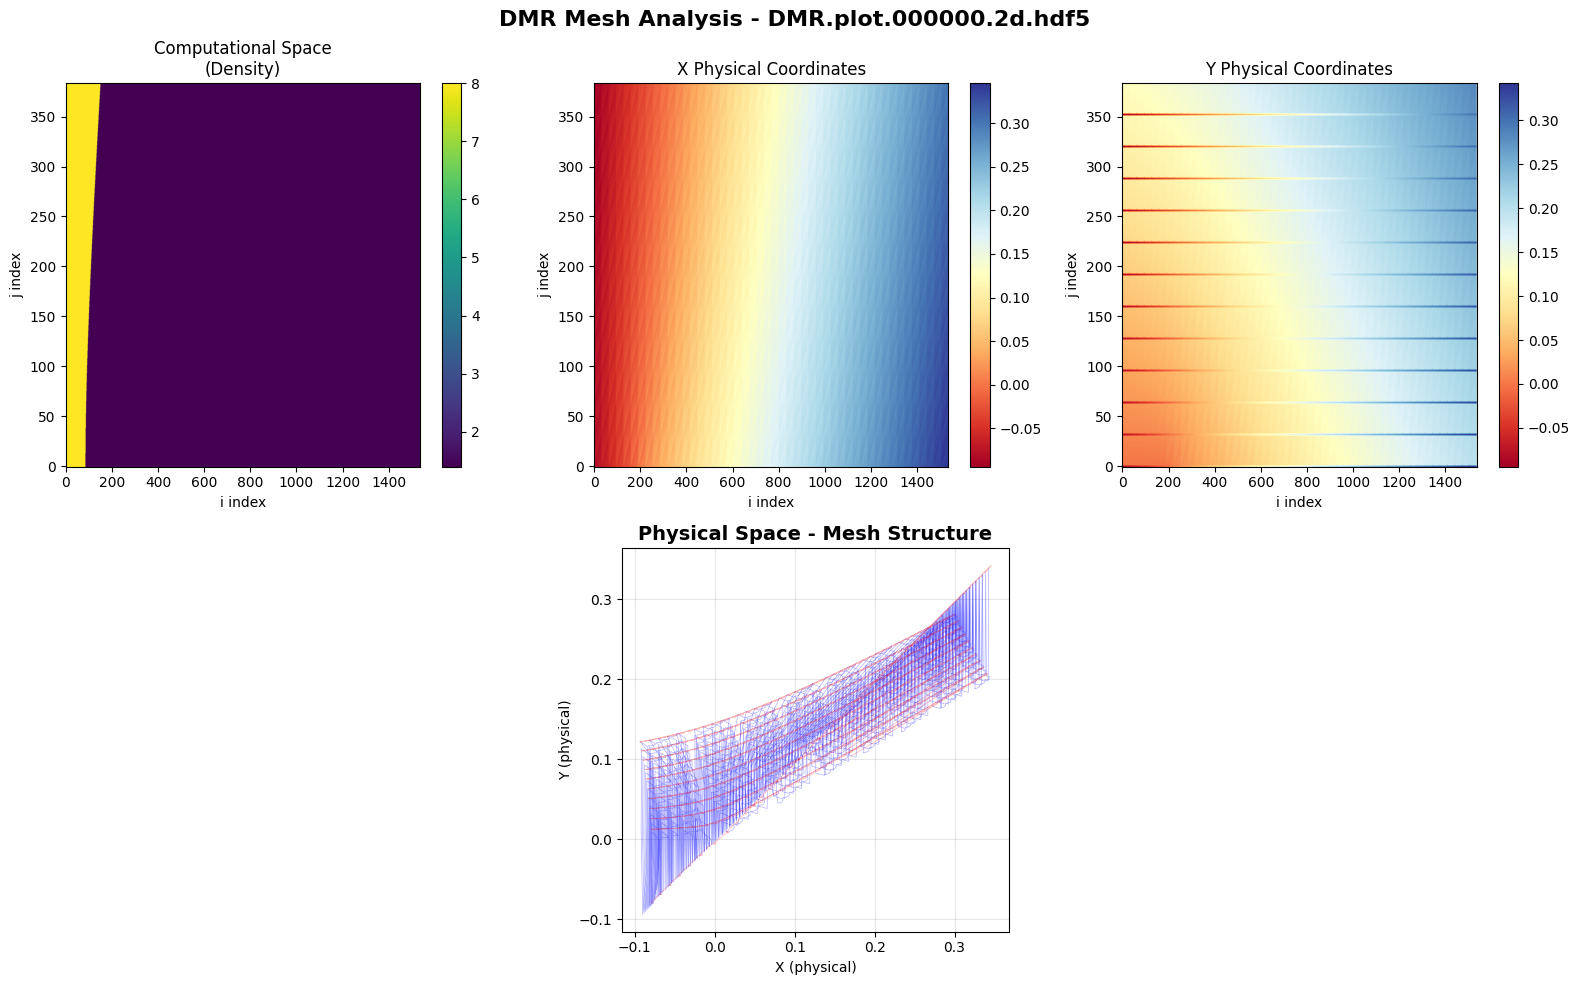


1️⃣  Comparing computational vs physical space...

📊 Comparing computational vs physical: DMR.plot.000000.2d.hdf5
💾 Saved: /standard/sds_baek_energetic/PSAAP - SAGEST/Chord_DoubleMachReflection_1536x394Cells_static/visualizations/dmr_comparison_t000000.png


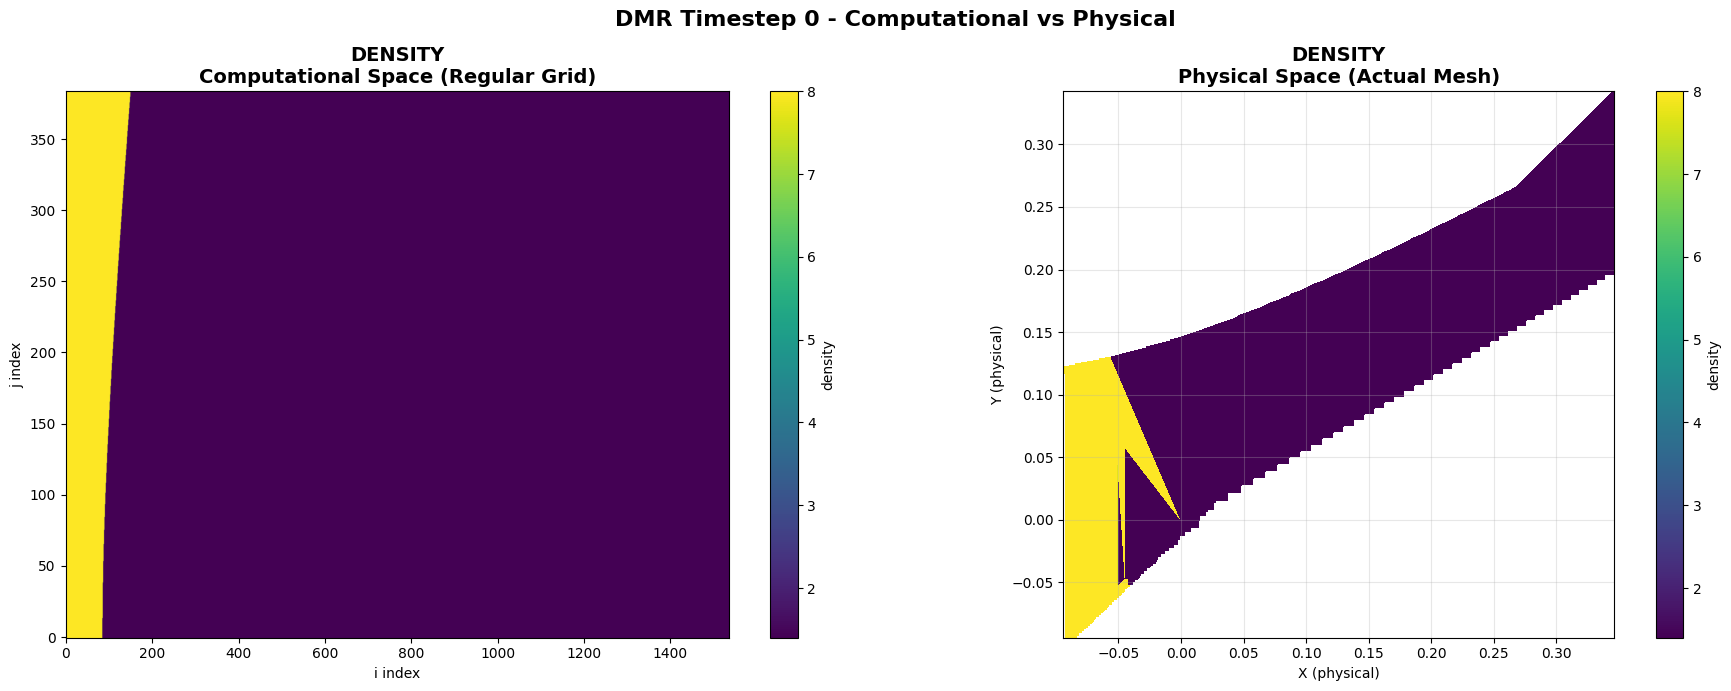


2️⃣  Visualizing all variables on physical mesh (t=0)...

🗺️  Visualizing on physical mesh: DMR.plot.000000.2d.hdf5
💾 Saved: /standard/sds_baek_energetic/PSAAP - SAGEST/Chord_DoubleMachReflection_1536x394Cells_static/visualizations/dmr_physical_mesh_t000000.png


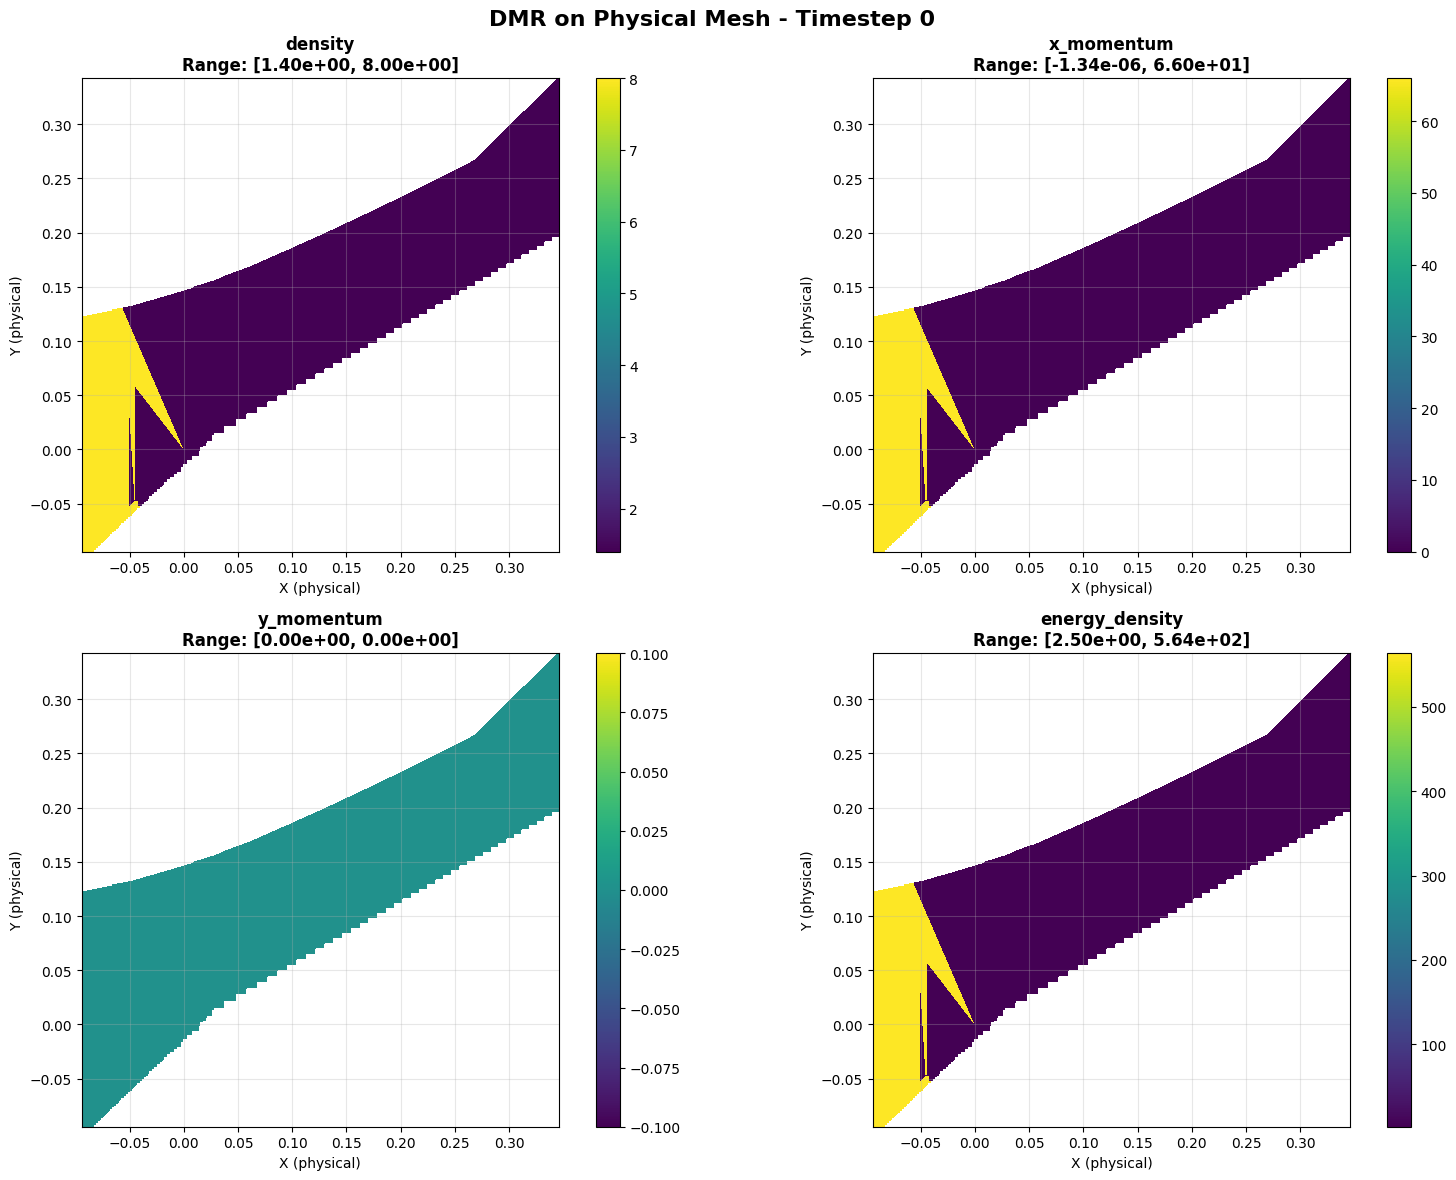


3️⃣  Visualizing physical mesh (t=1000)...

🗺️  Visualizing on physical mesh: DMR.plot.001000.2d.hdf5
💾 Saved: /standard/sds_baek_energetic/PSAAP - SAGEST/Chord_DoubleMachReflection_1536x394Cells_static/visualizations/dmr_physical_mesh_t001000.png


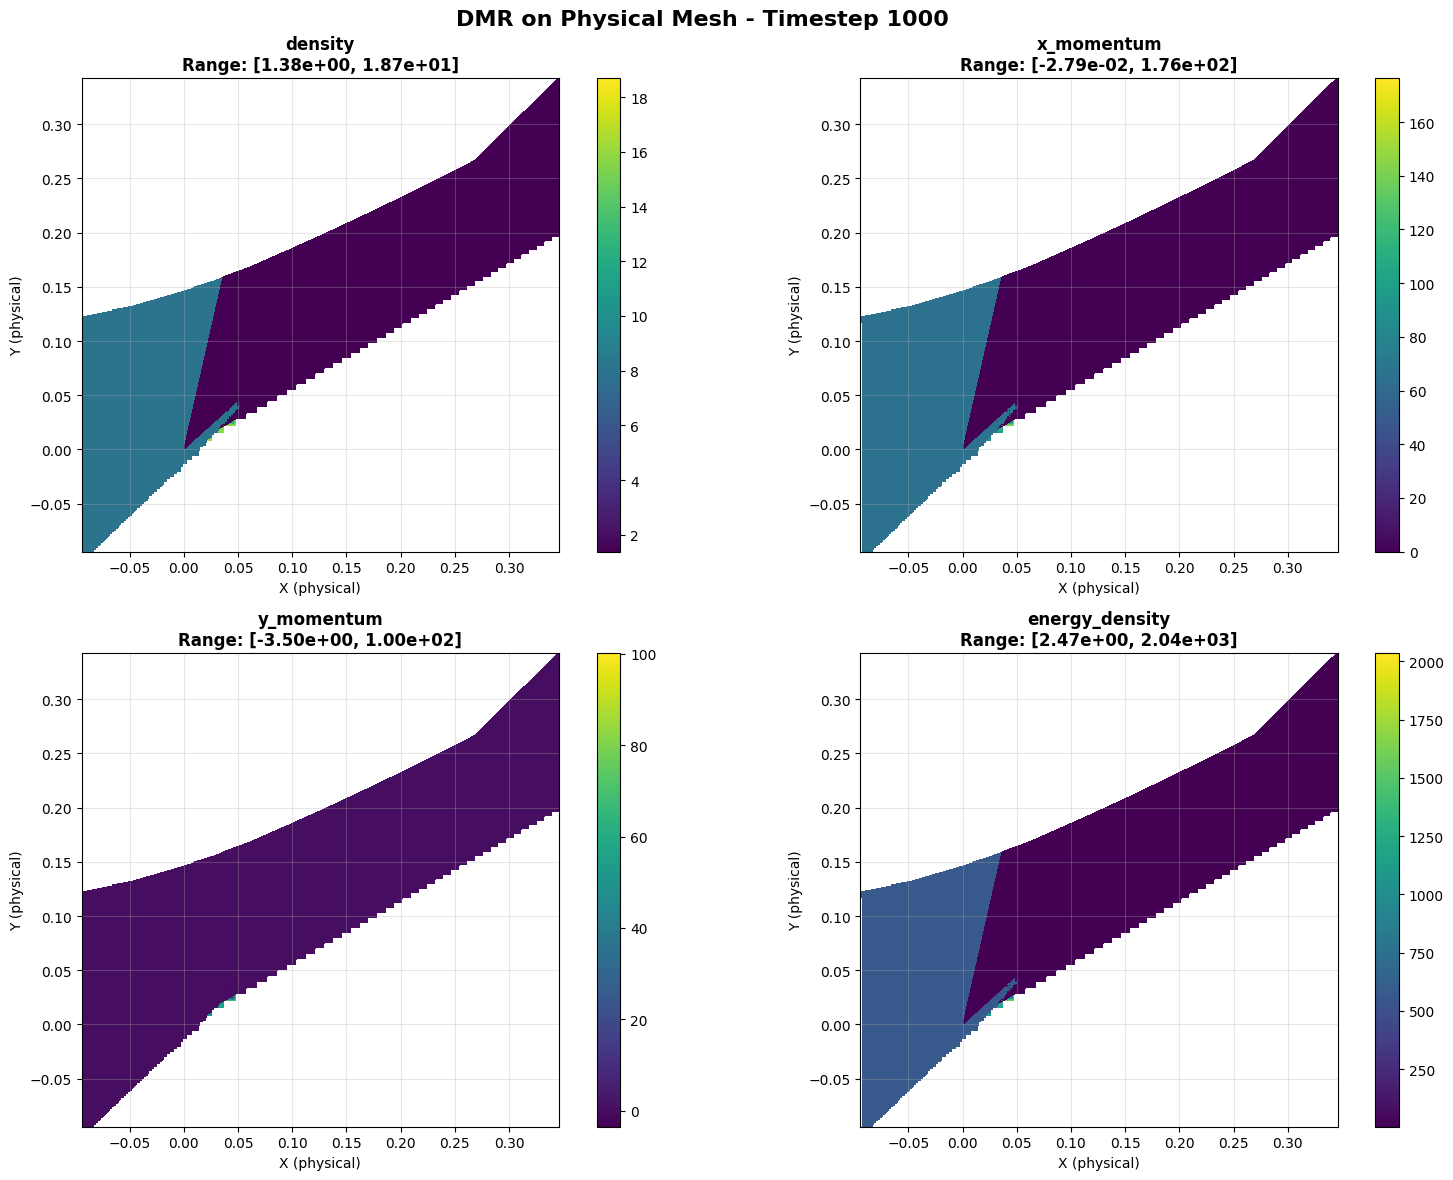


4️⃣  Create animation on physical mesh? (y/n): 

 y



  Animation settings:
  - GIF will be created automatically
  - PNG frames also saved for MP4 conversion if needed
🎬 Creating 251 animation frames on physical mesh...
  Computing global range...
  Range: [1.37e+00, 2.10e+01]
  Progress: 0/251
  Progress: 10/251
  Progress: 20/251
  Progress: 30/251
  Progress: 40/251
  Progress: 50/251
  Progress: 60/251
  Progress: 70/251
  Progress: 80/251
  Progress: 90/251
  Progress: 100/251
  Progress: 110/251
  Progress: 120/251
  Progress: 130/251
  Progress: 140/251
  Progress: 150/251
  Progress: 160/251
  Progress: 170/251
  Progress: 180/251
  Progress: 190/251
  Progress: 200/251
  Progress: 210/251
  Progress: 220/251
  Progress: 230/251
  Progress: 240/251
  Progress: 250/251
✅ PNG frames saved to: /standard/sds_baek_energetic/PSAAP - SAGEST/Chord_DoubleMachReflection_1536x394Cells_static/visualizations/animation_physical_mesh

🎬 Creating GIF...
✅ GIF saved: /standard/sds_baek_energetic/PSAAP - SAGEST/Chord_DoubleMachReflection_1536x394

In [3]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import re

class DMRVisualizer:
    """
    Visualize Double Mach Reflection simulation data.
    Handles Chombo HDF5 format with mapped coordinates (mesh data).
    """
    
    def __init__(self, data_dir):
        self.data_dir = Path(data_dir)
        self.grid_width = 1536
        self.grid_height = 384
        self.var_names = ['density', 'x_momentum', 'y_momentum', 'energy_density']
    
    def get_timestep_files(self, pattern="DMR.plot.*.2d.hdf5"):
        """Get sorted list of timestep files (excluding map files)."""
        files = [f for f in self.data_dir.glob(pattern) if '.map.' not in f.name]
        
        def extract_timestep(filename):
            match = re.search(r'\.(\d+)\.2d\.hdf5', str(filename))
            return int(match.group(1)) if match else 0
        
        return sorted(files, key=extract_timestep)
    
    def get_map_file(self, data_file):
        """Get corresponding map file for a data file."""
        map_filename = data_file.name.replace('.2d.hdf5', '.2d.map.hdf5')
        map_file = data_file.parent / map_filename
        return map_file if map_file.exists() else None
    
    def debug_box_structure(self, data_file):
        """Debug the box structure to understand data layout."""
        print(f"\n{'='*80}")
        print(f"🔍 DEBUGGING BOX STRUCTURE: {data_file.name}")
        print(f"{'='*80}")
        
        with h5py.File(data_file, 'r') as f:
            # Get number of variables from root attributes
            n_vars = int(f.attrs.get('num_components', 4))
            
            level = f['level_0']
            boxes = level['boxes'][:]
            data_flat = level['data:datatype=0'][:]
            offsets = level['data:offsets=0'][:]
            
            print(f"\n📊 Data Overview:")
            print(f"  Number of variables (from file): {n_vars}")
            print(f"  Total boxes: {len(boxes)}")
            print(f"  Data array shape: {data_flat.shape}")
            print(f"  Offsets shape: {offsets.shape} (one per box + 1)")
            
            print(f"\n📦 Box Analysis:")
            total_cells = 0
            empty_boxes = 0
            box_sizes = []
            
            for i, box in enumerate(boxes):
                ni = box['hi_i'] - box['lo_i'] + 1
                nj = box['hi_j'] - box['lo_j'] + 1
                box_size = ni * nj
                box_sizes.append(box_size)
                total_cells += box_size
                
                if box_size == 0:
                    empty_boxes += 1
                
                if i < 5:  # Print first 5 boxes
                    print(f"  Box {i}: lo=({box['lo_i']}, {box['lo_j']}), "
                          f"hi=({box['hi_i']}, {box['hi_j']}), size={ni}x{nj}={box_size}")
            
            print(f"\n  Total cells from boxes: {total_cells:,}")
            print(f"  Expected grid: {self.grid_width} × {self.grid_height} = {self.grid_width * self.grid_height:,}")
            print(f"  Empty boxes: {empty_boxes}")
            print(f"  Min box size: {min(box_sizes)}")
            print(f"  Max box size: {max(box_sizes)}")
            print(f"  Mean box size: {np.mean(box_sizes):.1f}")
            
            # Check if data matches expected size
            expected_data_size = total_cells * n_vars
            actual_data_size = data_flat.shape[0]
            
            print(f"\n📐 Data Size Check:")
            print(f"  Expected: {expected_data_size:,} ({total_cells:,} cells × {n_vars} vars)")
            print(f"  Actual: {actual_data_size:,}")
            print(f"  Match: {'✅' if expected_data_size == actual_data_size else '❌'}")
            
            # Analyze offsets
            print(f"\n📊 Offset Analysis:")
            print(f"  First 10 offsets: {offsets[:10]}")
            offset_diffs = np.diff(offsets)
            print(f"  Data per box (first 10): {offset_diffs[:10]}")
            print(f"  Expected per box: {box_sizes[0] * n_vars}")
            
            return boxes, data_flat, offsets, n_vars
    
    def read_chombo_data(self, data_file, map_file=None):
        """
        Read Chombo HDF5 data.
        CRITICAL: offsets array has one entry per BOX, not per variable!
        
        Returns:
            grids: dict of 2D arrays for each variable (computational space)
            coordinates: dict with 'x' and 'y' physical coordinates (if map_file provided)
        """
        with h5py.File(data_file, 'r') as f:
            # Get number of variables from file attributes
            n_vars = int(f.attrs.get('num_components', 4))
            
            level = f['level_0']
            boxes = level['boxes'][:]
            data_flat = level['data:datatype=0'][:]
            offsets = level['data:offsets=0'][:]
            
            # Initialize grids in computational space
            grids = {name: np.zeros((self.grid_height, self.grid_width)) 
                    for name in self.var_names}
            
            # Reconstruct 2D grids using offsets
            # offsets[i] to offsets[i+1] gives ALL data for box i
            for i, box in enumerate(boxes):
                ni = box['hi_i'] - box['lo_i'] + 1
                nj = box['hi_j'] - box['lo_j'] + 1
                box_size = ni * nj
                
                if box_size == 0:
                    continue
                
                # Get data slice for this box using offsets
                start_idx = offsets[i]
                end_idx = offsets[i + 1]
                box_data = data_flat[start_idx:end_idx]
                
                # Extract each variable from the box data
                # Data layout: [var0_cell0, var0_cell1, ..., var1_cell0, var1_cell1, ...]
                for var_idx in range(min(n_vars, len(self.var_names))):
                    var_start = var_idx * box_size
                    var_end = (var_idx + 1) * box_size
                    var_data = box_data[var_start:var_end]
                    
                    if len(var_data) == box_size:
                        var_data_2d = var_data.reshape((nj, ni))
                        grids[self.var_names[var_idx]][box['lo_j']:box['hi_j']+1, 
                                                       box['lo_i']:box['hi_i']+1] = var_data_2d
        
        # Read physical coordinates from map file
        coordinates = None
        if map_file and map_file.exists():
            with h5py.File(map_file, 'r') as f:
                n_coords = int(f.attrs.get('num_components', 2))
                
                level = f['level_0']
                boxes = level['boxes'][:]
                coord_flat = level['data:datatype=0'][:]
                offsets = level['data:offsets=0'][:]
                
                # Node-centered coordinates (one extra in each dimension)
                coord_grids = {
                    'x': np.zeros((self.grid_height + 1, self.grid_width + 1)),
                    'y': np.zeros((self.grid_height + 1, self.grid_width + 1))
                }
                
                for i, box in enumerate(boxes):
                    ni = box['hi_i'] - box['lo_i'] + 1
                    nj = box['hi_j'] - box['lo_j'] + 1
                    box_size = ni * nj
                    
                    if box_size == 0:
                        continue
                    
                    # Get coordinate data using offsets
                    start_idx = offsets[i]
                    end_idx = offsets[i + 1]
                    box_coords = coord_flat[start_idx:end_idx]
                    
                    # Extract x and y coordinates
                    if len(box_coords) >= box_size * n_coords:
                        x_data = box_coords[0:box_size].reshape((nj, ni))
                        y_data = box_coords[box_size:2*box_size].reshape((nj, ni))
                        
                        coord_grids['x'][box['lo_j']:box['hi_j']+1,
                                        box['lo_i']:box['hi_i']+1] = x_data
                        coord_grids['y'][box['lo_j']:box['hi_j']+1,
                                        box['lo_i']:box['hi_i']+1] = y_data
                
                # Convert node-centered to cell-centered coordinates
                coordinates = {
                    'x': (coord_grids['x'][:-1, :-1] + coord_grids['x'][:-1, 1:] + 
                          coord_grids['x'][1:, :-1] + coord_grids['x'][1:, 1:]) / 4.0,
                    'y': (coord_grids['y'][:-1, :-1] + coord_grids['y'][:-1, 1:] + 
                          coord_grids['y'][1:, :-1] + coord_grids['y'][1:, 1:]) / 4.0
                }
        
        return grids, coordinates
    
    def visualize_mesh_structure(self, timestep_idx=0, save_dir=None):
        """
        Visualize the mesh structure showing computational → physical mapping.
        """
        files = self.get_timestep_files()
        if timestep_idx >= len(files):
            print(f"❌ Timestep {timestep_idx} out of range (max: {len(files)-1})")
            return
        
        data_file = files[timestep_idx]
        map_file = self.get_map_file(data_file)
        
        if not map_file or not map_file.exists():
            print(f"❌ No map file found for {data_file.name}")
            return
        
        print(f"\n🗺️  Analyzing mesh structure: {data_file.name}")
        
        # Read data and coordinates
        grids, coords = self.read_chombo_data(data_file, map_file)
        
        if coords is None:
            print("❌ Could not read coordinates")
            return
        
        x_coords = coords['x']
        y_coords = coords['y']
        
        print(f"\n📊 Mesh Statistics:")
        print(f"  Computational grid: {self.grid_width} × {self.grid_height}")
        print(f"  X physical range: [{x_coords.min():.4f}, {x_coords.max():.4f}]")
        print(f"  Y physical range: [{y_coords.min():.4f}, {y_coords.max():.4f}]")
        
        # Create visualization
        fig = plt.figure(figsize=(16, 10))
        
        # Computational space - density
        ax1 = plt.subplot(2, 3, 1)
        im = ax1.imshow(grids['density'], origin='lower', aspect='auto', cmap='viridis')
        ax1.set_title('Computational Space\n(Density)', fontsize=12)
        ax1.set_xlabel('i index')
        ax1.set_ylabel('j index')
        plt.colorbar(im, ax=ax1)
        
        # X coordinates
        ax2 = plt.subplot(2, 3, 2)
        im = ax2.imshow(x_coords, origin='lower', aspect='auto', cmap='RdYlBu')
        ax2.set_title('X Physical Coordinates', fontsize=12)
        ax2.set_xlabel('i index')
        ax2.set_ylabel('j index')
        plt.colorbar(im, ax=ax2)
        
        # Y coordinates
        ax3 = plt.subplot(2, 3, 3)
        im = ax3.imshow(y_coords, origin='lower', aspect='auto', cmap='RdYlBu')
        ax3.set_title('Y Physical Coordinates', fontsize=12)
        ax3.set_xlabel('i index')
        ax3.set_ylabel('j index')
        plt.colorbar(im, ax=ax3)
        
        # Physical space - mesh lines
        ax4 = plt.subplot(2, 3, (4, 6))
        
        # Subsample mesh lines for visibility
        stride = max(1, self.grid_width // 40)
        
        # i-lines (constant i)
        for i in range(0, self.grid_width, stride):
            ax4.plot(x_coords[:, i], y_coords[:, i], 'b-', alpha=0.3, linewidth=0.5)
        
        # j-lines (constant j)
        for j in range(0, self.grid_height, stride):
            ax4.plot(x_coords[j, :], y_coords[j, :], 'r-', alpha=0.3, linewidth=0.5)
        
        ax4.set_title('Physical Space - Mesh Structure', fontsize=14, fontweight='bold')
        ax4.set_xlabel('X (physical)')
        ax4.set_ylabel('Y (physical)')
        ax4.set_aspect('equal', adjustable='box')
        ax4.grid(True, alpha=0.3)
        
        plt.suptitle(f"DMR Mesh Analysis - {data_file.name}", fontsize=16, fontweight='bold')
        plt.tight_layout()
        
        if save_dir:
            save_path = Path(save_dir)
            save_path.mkdir(exist_ok=True, parents=True)
            filename = save_path / "dmr_mesh_structure.png"
            plt.savefig(filename, dpi=150, bbox_inches='tight')
            print(f"💾 Saved: {filename}")
        
        plt.show()
    
    def visualize_timestep(self, timestep_idx=0, save_dir=None):
        """
        Visualize all variables at a single timestep.
        """
        files = self.get_timestep_files()
        if timestep_idx >= len(files):
            print(f"❌ Timestep {timestep_idx} out of range")
            return
        
        data_file = files[timestep_idx]
        map_file = self.get_map_file(data_file)
        
        print(f"\n📊 Visualizing: {data_file.name}")
        
        # Debug structure
        self.debug_box_structure(data_file)
        
        # Read data
        try:
            grids, coords = self.read_chombo_data(data_file, map_file)
        except Exception as e:
            print(f"❌ Error reading data: {e}")
            return
        
        # Create figure
        fig, axes = plt.subplots(2, 3, figsize=(18, 10))
        axes = axes.flatten()
        
        # Plot physics variables
        for i, var_name in enumerate(self.var_names):
            ax = axes[i]
            data = grids[var_name]
            
            im = ax.imshow(data, origin='lower', aspect='auto', cmap='viridis')
            ax.set_title(f"{var_name}\nRange: [{data.min():.2e}, {data.max():.2e}]", 
                        fontsize=10)
            ax.set_xlabel('i (computational)')
            ax.set_ylabel('j (computational)')
            plt.colorbar(im, ax=ax)
        
        # Plot coordinates if available
        if coords is not None:
            ax = axes[4]
            im = ax.imshow(coords['x'], origin='lower', aspect='auto', cmap='RdYlBu')
            ax.set_title(f"X Coordinates\n[{coords['x'].min():.2f}, {coords['x'].max():.2f}]", 
                        fontsize=10)
            plt.colorbar(im, ax=ax)
            
            ax = axes[5]
            im = ax.imshow(coords['y'], origin='lower', aspect='auto', cmap='RdYlBu')
            ax.set_title(f"Y Coordinates\n[{coords['y'].min():.2f}, {coords['y'].max():.2f}]", 
                        fontsize=10)
            plt.colorbar(im, ax=ax)
        else:
            axes[4].text(0.5, 0.5, 'No coordinate\ndata available', 
                        ha='center', va='center', transform=axes[4].transAxes)
            axes[5].axis('off')
        
        plt.suptitle(f"DMR Timestep {timestep_idx} - {data_file.name}", 
                    fontsize=14, fontweight='bold')
        plt.tight_layout()
        
        if save_dir:
            save_path = Path(save_dir)
            save_path.mkdir(exist_ok=True, parents=True)
            filename = save_path / f"dmr_timestep_{timestep_idx:06d}.png"
            plt.savefig(filename, dpi=150, bbox_inches='tight')
            print(f"💾 Saved: {filename}")
        
        plt.show()
    
    def visualize_on_physical_mesh(self, timestep_idx=0, variable='density', save_dir=None):
        """
        Visualize data on the actual physical mesh (not computational grid).
        Uses pcolormesh with actual physical coordinates.
        """
        files = self.get_timestep_files()
        if timestep_idx >= len(files):
            print(f"❌ Timestep {timestep_idx} out of range")
            return
        
        data_file = files[timestep_idx]
        map_file = self.get_map_file(data_file)
        
        if not map_file or not map_file.exists():
            print(f"❌ No map file found")
            return
        
        print(f"\n🗺️  Visualizing on physical mesh: {data_file.name}")
        
        # Read data and coordinates
        grids, coords = self.read_chombo_data(data_file, map_file)
        
        if coords is None:
            print("❌ Could not read coordinates")
            return
        
        # Get node-centered coordinates for pcolormesh
        with h5py.File(map_file, 'r') as f:
            level = f['level_0']
            boxes = level['boxes'][:]
            coord_flat = level['data:datatype=0'][:]
            offsets = level['data:offsets=0'][:]
            
            # Node-centered coordinates
            x_nodes = np.zeros((self.grid_height + 1, self.grid_width + 1))
            y_nodes = np.zeros((self.grid_height + 1, self.grid_width + 1))
            
            for i, box in enumerate(boxes):
                ni = box['hi_i'] - box['lo_i'] + 1
                nj = box['hi_j'] - box['lo_j'] + 1
                box_size = ni * nj
                
                if box_size == 0:
                    continue
                
                start_idx = offsets[i]
                end_idx = offsets[i + 1]
                box_coords = coord_flat[start_idx:end_idx]
                
                if len(box_coords) >= box_size * 2:
                    x_data = box_coords[0:box_size].reshape((nj, ni))
                    y_data = box_coords[box_size:2*box_size].reshape((nj, ni))
                    
                    x_nodes[box['lo_j']:box['hi_j']+1, box['lo_i']:box['hi_i']+1] = x_data
                    y_nodes[box['lo_j']:box['hi_j']+1, box['lo_i']:box['hi_i']+1] = y_data
        
        # Create figure with multiple variables
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        axes = axes.flatten()
        
        for i, var_name in enumerate(self.var_names):
            ax = axes[i]
            data = grids[var_name]
            
            # Use pcolormesh with actual physical coordinates
            im = ax.pcolormesh(x_nodes, y_nodes, data, cmap='viridis', shading='flat')
            ax.set_title(f"{var_name}\nRange: [{data.min():.2e}, {data.max():.2e}]", 
                        fontsize=12, fontweight='bold')
            ax.set_xlabel('X (physical)')
            ax.set_ylabel('Y (physical)')
            ax.set_aspect('equal', adjustable='box')
            ax.grid(True, alpha=0.3)
            plt.colorbar(im, ax=ax)
        
        plt.suptitle(f"DMR on Physical Mesh - Timestep {timestep_idx}", 
                    fontsize=16, fontweight='bold')
        plt.tight_layout()
        
        if save_dir:
            save_path = Path(save_dir)
            save_path.mkdir(exist_ok=True, parents=True)
            filename = save_path / f"dmr_physical_mesh_t{timestep_idx:06d}.png"
            plt.savefig(filename, dpi=150, bbox_inches='tight')
            print(f"💾 Saved: {filename}")
        
        plt.show()
    
    def compare_computational_vs_physical(self, timestep_idx=0, variable='density', save_dir=None):
        """
        Side-by-side comparison of computational grid vs physical mesh visualization.
        """
        files = self.get_timestep_files()
        if timestep_idx >= len(files):
            print(f"❌ Timestep {timestep_idx} out of range")
            return
        
        data_file = files[timestep_idx]
        map_file = self.get_map_file(data_file)
        
        if not map_file or not map_file.exists():
            print(f"❌ No map file found")
            return
        
        print(f"\n📊 Comparing computational vs physical: {data_file.name}")
        
        # Read data
        grids, coords = self.read_chombo_data(data_file, map_file)
        
        # Get node-centered coordinates
        with h5py.File(map_file, 'r') as f:
            level = f['level_0']
            boxes = level['boxes'][:]
            coord_flat = level['data:datatype=0'][:]
            offsets = level['data:offsets=0'][:]
            
            x_nodes = np.zeros((self.grid_height + 1, self.grid_width + 1))
            y_nodes = np.zeros((self.grid_height + 1, self.grid_width + 1))
            
            for i, box in enumerate(boxes):
                ni = box['hi_i'] - box['lo_i'] + 1
                nj = box['hi_j'] - box['lo_j'] + 1
                box_size = ni * nj
                
                if box_size == 0:
                    continue
                
                start_idx = offsets[i]
                end_idx = offsets[i + 1]
                box_coords = coord_flat[start_idx:end_idx]
                
                if len(box_coords) >= box_size * 2:
                    x_data = box_coords[0:box_size].reshape((nj, ni))
                    y_data = box_coords[box_size:2*box_size].reshape((nj, ni))
                    
                    x_nodes[box['lo_j']:box['hi_j']+1, box['lo_i']:box['hi_i']+1] = x_data
                    y_nodes[box['lo_j']:box['hi_j']+1, box['lo_i']:box['hi_i']+1] = y_data
        
        data = grids[variable]
        
        # Create comparison figure
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
        
        # Computational grid (rectangular)
        im1 = ax1.imshow(data, origin='lower', aspect='auto', cmap='viridis')
        ax1.set_title(f'{variable.upper()}\nComputational Space (Regular Grid)', 
                     fontsize=14, fontweight='bold')
        ax1.set_xlabel('i index')
        ax1.set_ylabel('j index')
        plt.colorbar(im1, ax=ax1, label=variable)
        
        # Physical mesh (actual geometry)
        im2 = ax2.pcolormesh(x_nodes, y_nodes, data, cmap='viridis', shading='flat',
                            vmin=data.min(), vmax=data.max())
        ax2.set_title(f'{variable.upper()}\nPhysical Space (Actual Mesh)', 
                     fontsize=14, fontweight='bold')
        ax2.set_xlabel('X (physical)')
        ax2.set_ylabel('Y (physical)')
        ax2.set_aspect('equal', adjustable='box')
        ax2.grid(True, alpha=0.3)
        plt.colorbar(im2, ax=ax2, label=variable)
        
        plt.suptitle(f"DMR Timestep {timestep_idx} - Computational vs Physical", 
                    fontsize=16, fontweight='bold')
        plt.tight_layout()
        
        if save_dir:
            save_path = Path(save_dir)
            save_path.mkdir(exist_ok=True, parents=True)
            filename = save_path / f"dmr_comparison_t{timestep_idx:06d}.png"
            plt.savefig(filename, dpi=150, bbox_inches='tight')
            print(f"💾 Saved: {filename}")
        
        plt.show()
    
    def animate_on_physical_mesh(self, variable='density', timesteps=None, 
                                stride=10, max_frames=100, save_dir=None,
                                create_gif=True, fps=30):
        """
        Create animation frames showing data on physical mesh.
        Optionally creates a GIF directly.
        """
        files = self.get_timestep_files()
        
        if timesteps is None:
            timesteps = range(0, min(len(files), max_frames * stride), stride)
        
        selected_files = [files[i] for i in timesteps if i < len(files)]
        
        print(f"🎬 Creating {len(selected_files)} animation frames on physical mesh...")
        
        # Get global range for consistent colorbar
        print("  Computing global range...")
        vmin, vmax = float('inf'), float('-inf')
        for i, file in enumerate(selected_files[::5]):  # Sample every 5th
            try:
                grids, _ = self.read_chombo_data(file)
                data = grids[variable]
                vmin = min(vmin, data.min())
                vmax = max(vmax, data.max())
            except:
                pass
        
        print(f"  Range: [{vmin:.2e}, {vmax:.2e}]")
        
        if save_dir:
            output_path = Path(save_dir) / "animation_physical_mesh"
            output_path.mkdir(exist_ok=True, parents=True)
        else:
            output_path = Path("./animation_physical_mesh")
            output_path.mkdir(exist_ok=True, parents=True)
        
        # Store frames for GIF
        if create_gif:
            try:
                from PIL import Image
                import io
                gif_frames = []
            except ImportError:
                print("  ⚠️ PIL not available, will only save PNG frames")
                create_gif = False
        
        # Create frames
        for frame_idx, (timestep, file) in enumerate(zip(timesteps, selected_files)):
            if frame_idx % 10 == 0:
                print(f"  Progress: {frame_idx}/{len(selected_files)}")
            
            try:
                map_file = self.get_map_file(file)
                if not map_file:
                    continue
                
                # Read data
                grids, _ = self.read_chombo_data(file, map_file)
                data = grids[variable]
                
                # Get node coordinates
                with h5py.File(map_file, 'r') as f:
                    level = f['level_0']
                    boxes = level['boxes'][:]
                    coord_flat = level['data:datatype=0'][:]
                    offsets = level['data:offsets=0'][:]
                    
                    x_nodes = np.zeros((self.grid_height + 1, self.grid_width + 1))
                    y_nodes = np.zeros((self.grid_height + 1, self.grid_width + 1))
                    
                    for i, box in enumerate(boxes):
                        ni = box['hi_i'] - box['lo_i'] + 1
                        nj = box['hi_j'] - box['lo_j'] + 1
                        box_size = ni * nj
                        
                        if box_size == 0:
                            continue
                        
                        start_idx = offsets[i]
                        end_idx = offsets[i + 1]
                        box_coords = coord_flat[start_idx:end_idx]
                        
                        if len(box_coords) >= box_size * 2:
                            x_data = box_coords[0:box_size].reshape((nj, ni))
                            y_data = box_coords[box_size:2*box_size].reshape((nj, ni))
                            
                            x_nodes[box['lo_j']:box['hi_j']+1, box['lo_i']:box['hi_i']+1] = x_data
                            y_nodes[box['lo_j']:box['hi_j']+1, box['lo_i']:box['hi_i']+1] = y_data
                
                # Plot
                fig, ax = plt.subplots(figsize=(14, 6))
                im = ax.pcolormesh(x_nodes, y_nodes, data, cmap='viridis', 
                                 shading='flat', vmin=vmin, vmax=vmax)
                ax.set_title(f"{variable.upper()} - Timestep {timestep} ({file.name})", 
                           fontsize=14, fontweight='bold')
                ax.set_xlabel('X (physical)')
                ax.set_ylabel('Y (physical)')
                ax.set_aspect('equal', adjustable='box')
                ax.grid(True, alpha=0.3)
                plt.colorbar(im, ax=ax, label=variable)
                
                # Save PNG
                filename = output_path / f"frame_{frame_idx:06d}.png"
                plt.savefig(filename, dpi=100, bbox_inches='tight')
                
                # Add to GIF frames
                if create_gif:
                    buf = io.BytesIO()
                    plt.savefig(buf, format='png', dpi=100, bbox_inches='tight')
                    buf.seek(0)
                    gif_frames.append(Image.open(buf))
                
                plt.close()
                
            except Exception as e:
                print(f"  ⚠️ Error at frame {frame_idx}: {e}")
                continue
        
        print(f"✅ PNG frames saved to: {output_path}")
        
        # Create GIF
        if create_gif and gif_frames:
            gif_path = output_path.parent / f"dmr_{variable}_physical_mesh.gif"
            print(f"\n🎬 Creating GIF...")
            
            # Calculate duration per frame in milliseconds
            duration = int(1000 / fps)
            
            gif_frames[0].save(
                gif_path,
                save_all=True,
                append_images=gif_frames[1:],
                duration=duration,
                loop=0,
                optimize=False
            )
            print(f"✅ GIF saved: {gif_path}")
            print(f"   Frames: {len(gif_frames)}, FPS: {fps}")
        
        # Also provide ffmpeg command for MP4 if desired
        print(f"\n💡 Alternative - Create MP4 with:")
        print(f"   ffmpeg -framerate {fps} -pattern_type glob -i '{output_path}/frame_*.png' \\")
        print(f"          -c:v libx264 -pix_fmt yuv420p dmr_{variable}_physical_mesh.mp4")
    
    def visualize_time_evolution(self, timesteps=[0, 500, 1000, 1500, 2000, 2500], 
                                 variable='density', save_dir=None):
        """
        Show evolution of a variable across multiple timesteps.
        """
        files = self.get_timestep_files()
        valid_timesteps = [t for t in timesteps if t < len(files)]
        
        if not valid_timesteps:
            print("❌ No valid timesteps")
            return
        
        print(f"📈 Loading {variable} evolution...")
        
        # Load data and find global range
        all_data = []
        for idx in valid_timesteps:
            try:
                grids, _ = self.read_chombo_data(files[idx])
                all_data.append(grids[variable])
            except Exception as e:
                print(f"  ⚠️ Error at timestep {idx}: {e}")
                all_data.append(None)
        
        valid_data = [d for d in all_data if d is not None]
        if not valid_data:
            print("❌ No valid data")
            return
        
        vmin = min(d.min() for d in valid_data)
        vmax = max(d.max() for d in valid_data)
        print(f"  Range: [{vmin:.2e}, {vmax:.2e}]")
        
        # Plot
        fig, axes = plt.subplots(2, 3, figsize=(18, 10))
        axes = axes.flatten()
        
        for i, (idx, data) in enumerate(zip(valid_timesteps[:6], all_data[:6])):
            ax = axes[i]
            if data is not None:
                im = ax.imshow(data, origin='lower', aspect='auto', 
                             cmap='viridis', vmin=vmin, vmax=vmax)
                ax.set_title(f"Timestep {idx}", fontsize=12)
                plt.colorbar(im, ax=ax)
            else:
                ax.text(0.5, 0.5, f'Error\ntimestep {idx}', 
                       ha='center', va='center', transform=ax.transAxes)
                ax.axis('off')
        
        for i in range(len(valid_timesteps), 6):
            axes[i].axis('off')
        
        plt.suptitle(f"DMR - {variable.upper()} Evolution", 
                    fontsize=14, fontweight='bold')
        plt.tight_layout()
        
        if save_dir:
            save_path = Path(save_dir)
            save_path.mkdir(exist_ok=True, parents=True)
            filename = save_path / f"dmr_{variable}_evolution.png"
            plt.savefig(filename, dpi=150, bbox_inches='tight')
            print(f"💾 Saved: {filename}")
        
        plt.show()


def main():
    """Main visualization script."""
    BASE_DIR = "/standard/sds_baek_energetic/PSAAP - SAGEST/Chord_DoubleMachReflection_1536x394Cells_static/static_noAMR_mapped_coordinates"
    SAVE_DIR = "/standard/sds_baek_energetic/PSAAP - SAGEST/Chord_DoubleMachReflection_1536x394Cells_static/visualizations"
    
    print("="*80)
    print("🎨 DMR DATA VISUALIZATION TOOL")
    print("="*80)
    
    visualizer = DMRVisualizer(BASE_DIR)
    
    # Visualize mesh structure
    print("\n0️⃣  Analyzing mesh structure...")
    visualizer.visualize_mesh_structure(timestep_idx=0, save_dir=SAVE_DIR)
    
    # Compare computational vs physical
    print("\n1️⃣  Comparing computational vs physical space...")
    visualizer.compare_computational_vs_physical(timestep_idx=0, variable='density', 
                                                save_dir=SAVE_DIR)
    
    # Visualize on physical mesh
    print("\n2️⃣  Visualizing all variables on physical mesh (t=0)...")
    visualizer.visualize_on_physical_mesh(timestep_idx=0, save_dir=SAVE_DIR)
    
    # Middle timestep on physical mesh
    print("\n3️⃣  Visualizing physical mesh (t=1000)...")
    visualizer.visualize_on_physical_mesh(timestep_idx=1000, save_dir=SAVE_DIR)
    
    # Optional: create animation
    print("\n4️⃣  Create animation on physical mesh? (y/n): ", end="")
    create_anim = input().lower().strip() in ['y', 'yes']
    
    if create_anim:
        print("\n  Animation settings:")
        print("  - GIF will be created automatically")
        print("  - PNG frames also saved for MP4 conversion if needed")
        
        visualizer.animate_on_physical_mesh(
            variable='density',
            stride=10,
            max_frames=1000,
            save_dir=SAVE_DIR,
            create_gif=True,  # Creates GIF directly
            fps=30  # Frames per second
        )
    
    print("\n✅ Visualization complete!")


if __name__ == "__main__":
    main()

🎨 DMR DATA VISUALIZATION TOOL (FIXED)

0️⃣  Analyzing mesh structure...
📍 Reading mesh coordinates from: DMR.plot.000000.2d.map.hdf5
  Cell-centered coords: (394, 1536)
  Node-centered coords: (395, 1537)
  X range: [-0.094, 0.346]
  Y range: [-0.094, 0.342]
💾 Saved: /standard/sds_baek_energetic/PSAAP - SAGEST/Chord_DoubleMachReflection_1536x394Cells_static/visualizations/dmr_mesh_structure_t0.png


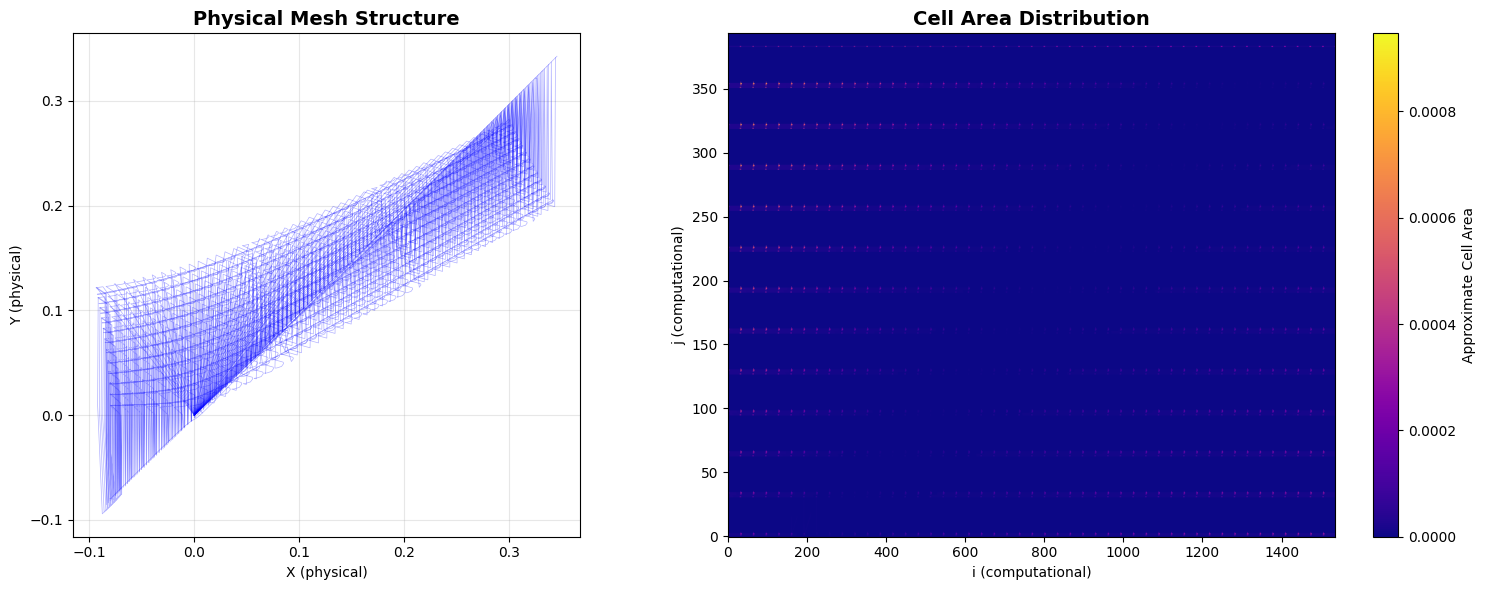


1️⃣  Comparing computational vs physical space...
📊 Loading density from: DMR.plot.000000.2d.hdf5
  Range: [0.00e+00, 8.00e+00]
💾 Saved: /standard/sds_baek_energetic/PSAAP - SAGEST/Chord_DoubleMachReflection_1536x394Cells_static/visualizations/dmr_density_comparison_t0.png


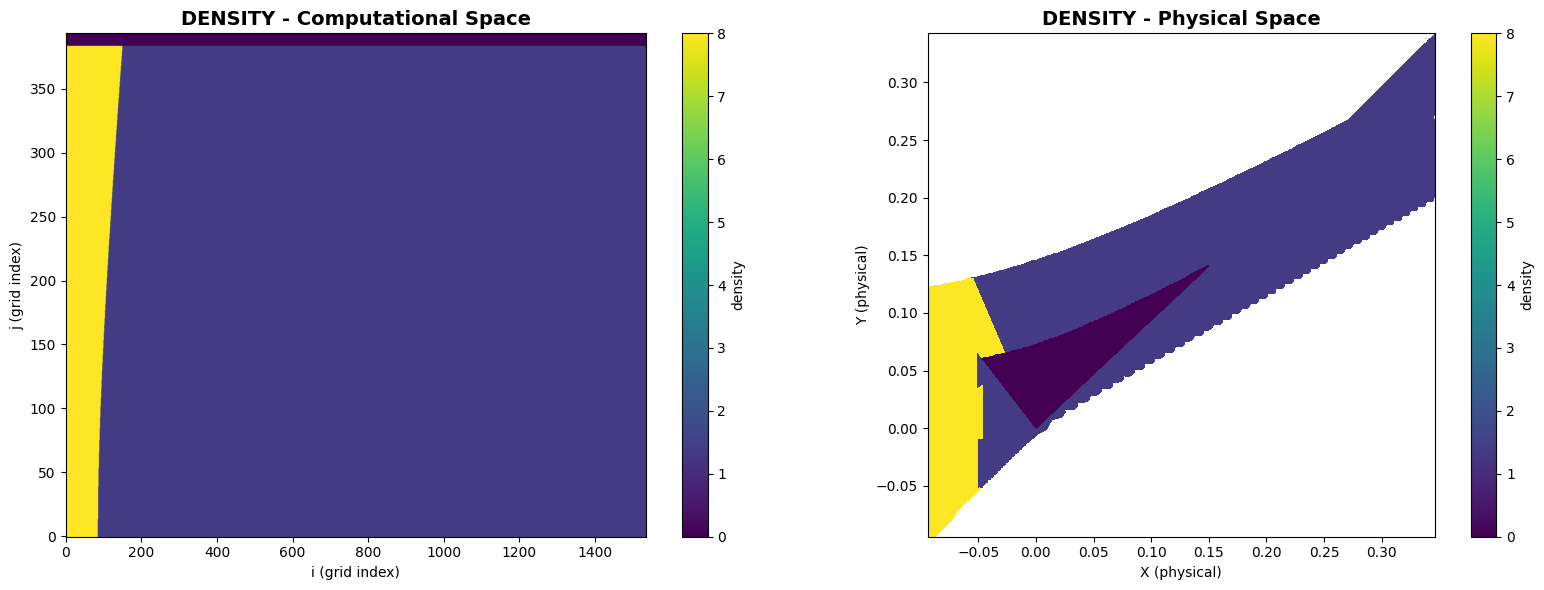


2️⃣  Visualizing all variables on physical mesh (t=0)...
📊 Loading all variables from: DMR.plot.000000.2d.hdf5
  density: [0.00e+00, 8.00e+00]
  x_momentum: [-1.34e-06, 6.60e+01]
  y_momentum: [0.00e+00, 0.00e+00]
  energy_density: [0.00e+00, 5.64e+02]
💾 Saved: /standard/sds_baek_energetic/PSAAP - SAGEST/Chord_DoubleMachReflection_1536x394Cells_static/visualizations/dmr_all_vars_physical_t0.png


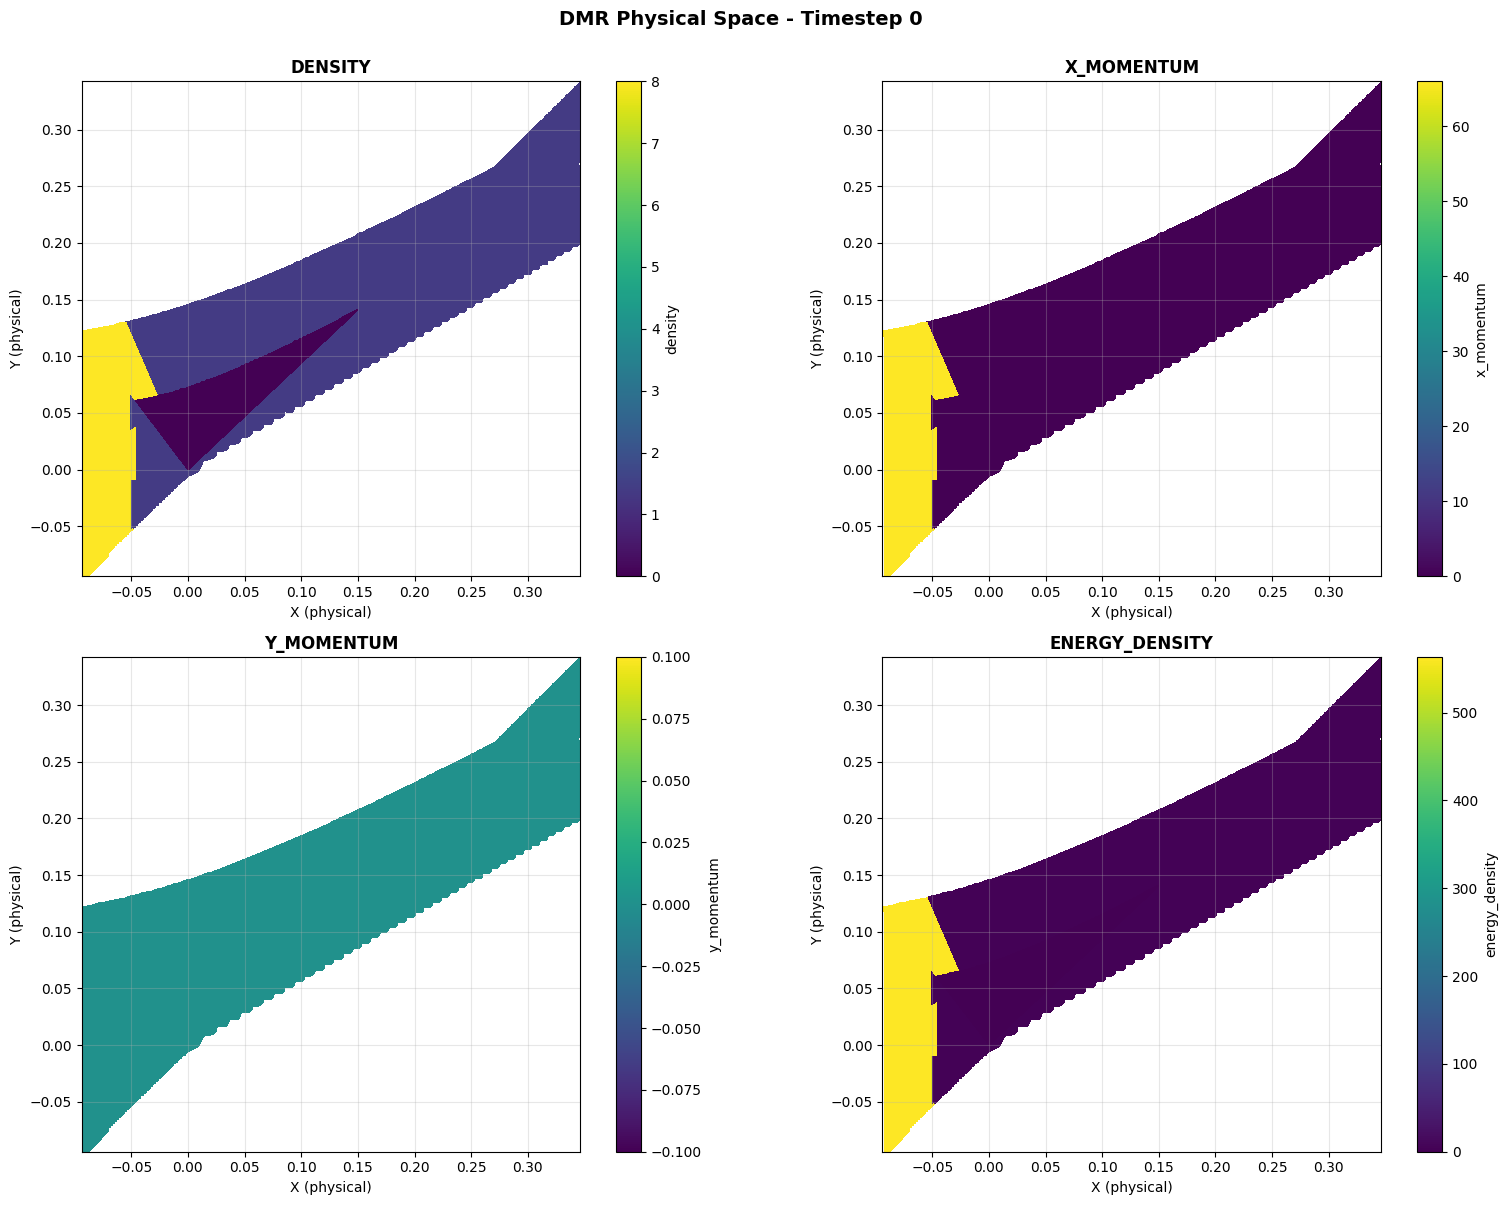


3️⃣  Visualizing physical mesh (t=1000)...
📊 Loading all variables from: DMR.plot.001000.2d.hdf5
  density: [0.00e+00, 1.87e+01]
  x_momentum: [-2.79e-02, 1.76e+02]
  y_momentum: [-3.50e+00, 1.00e+02]
  energy_density: [0.00e+00, 2.04e+03]
💾 Saved: /standard/sds_baek_energetic/PSAAP - SAGEST/Chord_DoubleMachReflection_1536x394Cells_static/visualizations/dmr_all_vars_physical_t1000.png


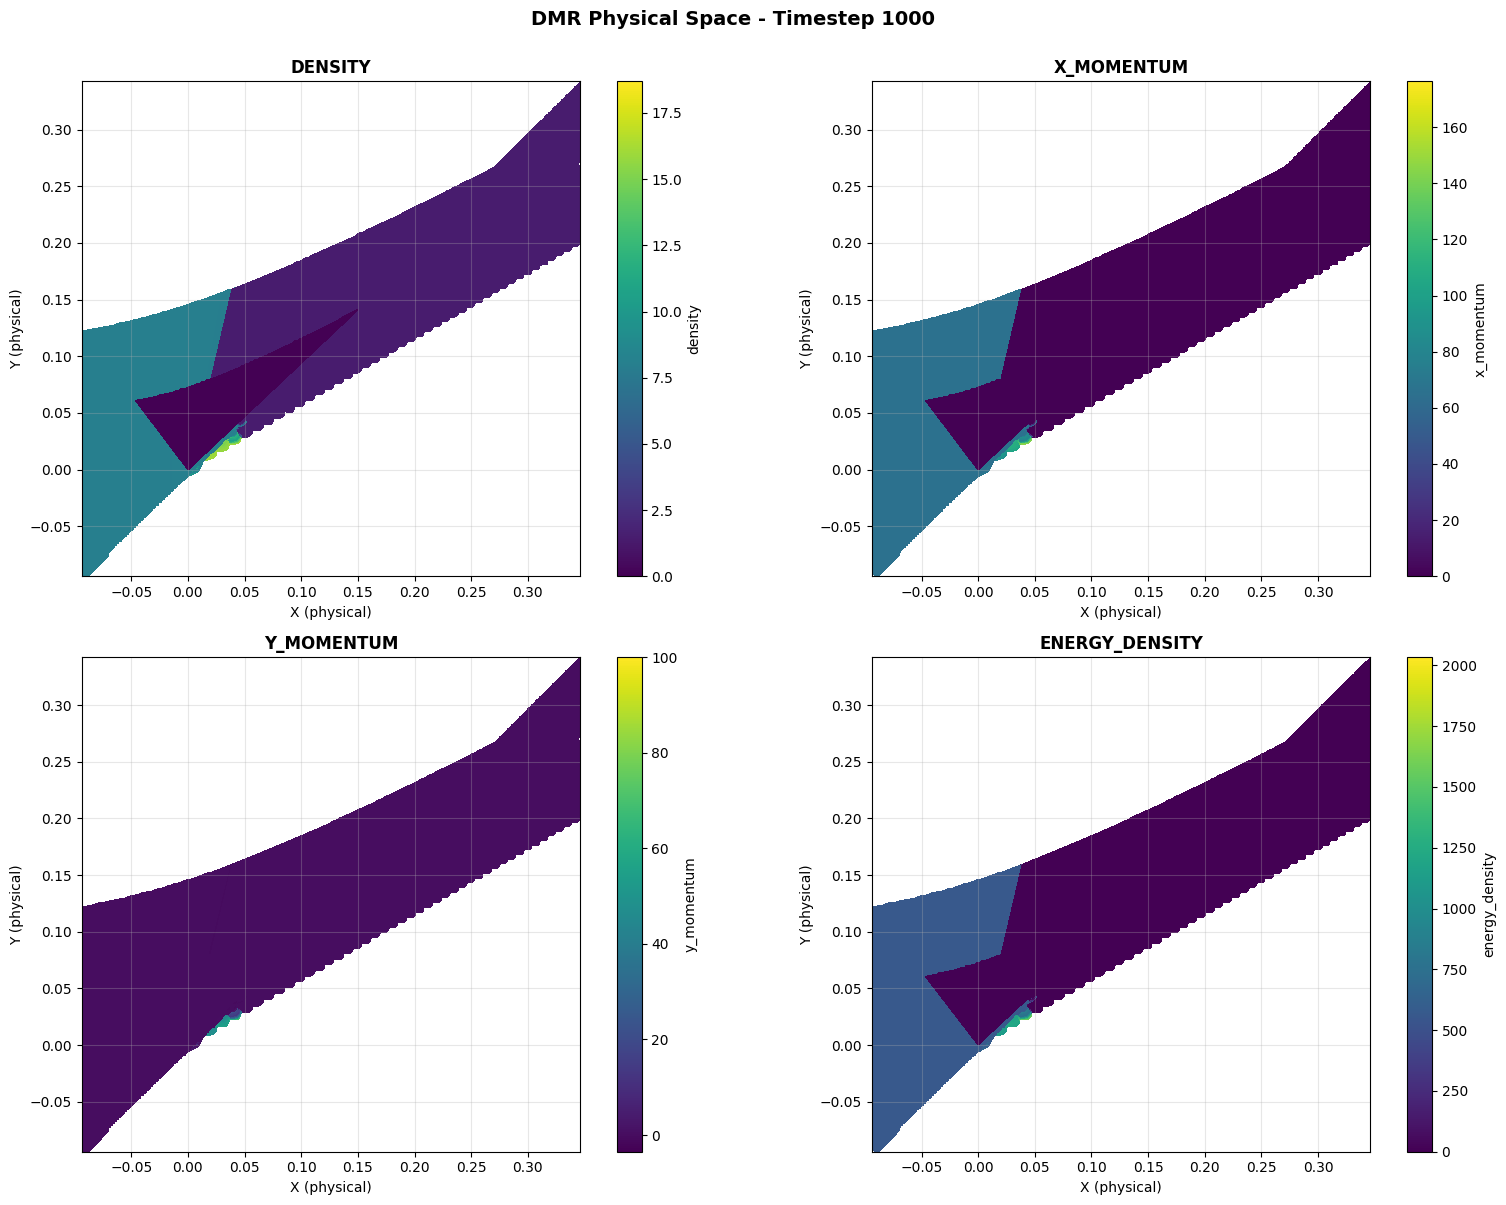


4️⃣  Create animation on physical mesh? (y/n): 

 y



  Animation settings:
  - GIF will be created automatically
  - PNG frames also saved for MP4 conversion if needed
🎬 Creating animation for density
  Total frames: 2501
  Stride: 1
📊 Finding global range...
  Global range: [0.00e+00, 8.03e+00]
  Frame 46/2501: DMR.plot.000045.2d.hdf5

In [ ]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import re
import io
from PIL import Image

class DMRVisualizer:
    """
    Visualize Double Mach Reflection simulation data.
    Handles Chombo HDF5 format with mapped coordinates (mesh data).
    """
    
    def __init__(self, data_dir):
        self.data_dir = Path(data_dir)
        self.grid_width = 1536
        self.grid_height = 394  # FIXED: Was 384, should be 394
        self.var_names = ['density', 'x_momentum', 'y_momentum', 'energy_density']
    
    def get_timestep_files(self, pattern="DMR.plot.*.2d.hdf5"):
        """Get sorted list of timestep files (excluding map files)."""
        files = [f for f in self.data_dir.glob(pattern) if '.map.' not in f.name]
        
        def extract_timestep(filename):
            match = re.search(r'\.(\d+)\.2d\.hdf5', str(filename))
            return int(match.group(1)) if match else 0
        
        return sorted(files, key=extract_timestep)
    
    def get_map_file(self, data_file):
        """Get corresponding map file for a data file."""
        map_filename = data_file.name.replace('.2d.hdf5', '.2d.map.hdf5')
        map_file = data_file.parent / map_filename
        return map_file if map_file.exists() else None
    
    def debug_box_structure(self, data_file):
        """Debug the box structure to understand data layout."""
        print(f"\n{'='*80}")
        print(f"🔍 DEBUGGING BOX STRUCTURE: {data_file.name}")
        print(f"{'='*80}")
        
        with h5py.File(data_file, 'r') as f:
            # Get number of variables from root attributes
            n_vars = int(f.attrs.get('num_components', 4))
            
            level = f['level_0']
            boxes = level['boxes'][:]
            data_flat = level['data:datatype=0'][:]
            offsets = level['data:offsets=0'][:]
            
            print(f"\n📊 Data Overview:")
            print(f"  Number of variables (from file): {n_vars}")
            print(f"  Total boxes: {len(boxes)}")
            print(f"  Data array shape: {data_flat.shape}")
            print(f"  Offsets shape: {offsets.shape} (one per box + 1)")
            
            print(f"\n📦 Box Analysis:")
            total_cells = 0
            empty_boxes = 0
            box_sizes = []
            
            for i, box in enumerate(boxes):
                ni = box['hi_i'] - box['lo_i'] + 1
                nj = box['hi_j'] - box['lo_j'] + 1
                box_size = ni * nj
                box_sizes.append(box_size)
                total_cells += box_size
                
                if box_size == 0:
                    empty_boxes += 1
                
                if i < 5:  # Print first 5 boxes
                    print(f"  Box {i}: lo=({box['lo_i']}, {box['lo_j']}), "
                          f"hi=({box['hi_i']}, {box['hi_j']}), size={ni}x{nj}={box_size}")
            
            print(f"\n  Total cells from boxes: {total_cells:,}")
            print(f"  Expected grid: {self.grid_width} × {self.grid_height} = {self.grid_width * self.grid_height:,}")
            print(f"  Empty boxes: {empty_boxes}")
            print(f"  Min box size: {min(box_sizes)}")
            print(f"  Max box size: {max(box_sizes)}")
            print(f"  Mean box size: {np.mean(box_sizes):.1f}")
            
            # Check if data matches expected size
            expected_data_size = total_cells * n_vars
            actual_data_size = data_flat.shape[0]
            
            print(f"\n📐 Data Size Check:")
            print(f"  Expected: {expected_data_size:,} ({total_cells:,} cells × {n_vars} vars)")
            print(f"  Actual: {actual_data_size:,}")
            print(f"  Match: {'✅' if expected_data_size == actual_data_size else '❌'}")
            
            # Analyze offsets
            print(f"\n📊 Offset Analysis:")
            print(f"  First 10 offsets: {offsets[:10]}")
            offset_diffs = np.diff(offsets)
            print(f"  Data per box (first 10): {offset_diffs[:10]}")
            print(f"  Expected per box: {box_sizes[0] * n_vars}")
            
            return boxes, data_flat, offsets, n_vars
    
    def cell_to_node_coords(self, x_cell, y_cell):
        """
        Convert cell-centered coordinates to node-centered coordinates for pcolormesh.
        Uses linear extrapolation at boundaries and averaging in interior.
        
        Args:
            x_cell, y_cell: Cell-centered coordinate arrays of shape (nj, ni)
            
        Returns:
            x_node, y_node: Node-centered coordinate arrays of shape (nj+1, ni+1)
        """
        nj, ni = x_cell.shape
        x_node = np.zeros((nj + 1, ni + 1))
        y_node = np.zeros((nj + 1, ni + 1))
        
        # Interior nodes: average of surrounding cell centers
        x_node[1:-1, 1:-1] = 0.25 * (x_cell[:-1, :-1] + x_cell[1:, :-1] + 
                                      x_cell[:-1, 1:] + x_cell[1:, 1:])
        y_node[1:-1, 1:-1] = 0.25 * (y_cell[:-1, :-1] + y_cell[1:, :-1] + 
                                      y_cell[:-1, 1:] + y_cell[1:, 1:])
        
        # Edge nodes: average of two adjacent cell centers
        # Bottom edge
        x_node[0, 1:-1] = 0.5 * (x_cell[0, :-1] + x_cell[0, 1:])
        y_node[0, 1:-1] = 0.5 * (y_cell[0, :-1] + y_cell[0, 1:])
        
        # Top edge
        x_node[-1, 1:-1] = 0.5 * (x_cell[-1, :-1] + x_cell[-1, 1:])
        y_node[-1, 1:-1] = 0.5 * (y_cell[-1, :-1] + y_cell[-1, 1:])
        
        # Left edge
        x_node[1:-1, 0] = 0.5 * (x_cell[:-1, 0] + x_cell[1:, 0])
        y_node[1:-1, 0] = 0.5 * (y_cell[:-1, 0] + y_cell[1:, 0])
        
        # Right edge
        x_node[1:-1, -1] = 0.5 * (x_cell[:-1, -1] + x_cell[1:, -1])
        y_node[1:-1, -1] = 0.5 * (y_cell[:-1, -1] + y_cell[1:, -1])
        
        # Corner nodes: extrapolate from nearby cell centers
        # Bottom-left corner
        x_node[0, 0] = 1.5 * x_cell[0, 0] - 0.5 * x_cell[0, 1]
        y_node[0, 0] = 1.5 * y_cell[0, 0] - 0.5 * y_cell[1, 0]
        
        # Bottom-right corner
        x_node[0, -1] = 1.5 * x_cell[0, -1] - 0.5 * x_cell[0, -2]
        y_node[0, -1] = 1.5 * y_cell[0, -1] - 0.5 * y_cell[1, -1]
        
        # Top-left corner
        x_node[-1, 0] = 1.5 * x_cell[-1, 0] - 0.5 * x_cell[-1, 1]
        y_node[-1, 0] = 1.5 * y_cell[-1, 0] - 0.5 * y_cell[-2, 0]
        
        # Top-right corner
        x_node[-1, -1] = 1.5 * x_cell[-1, -1] - 0.5 * x_cell[-1, -2]
        y_node[-1, -1] = 1.5 * y_cell[-1, -1] - 0.5 * y_cell[-2, -1]
        
        return x_node, y_node
    
    def read_chombo_data(self, data_file, map_file=None):
        """
        Read Chombo HDF5 data.
        CRITICAL: offsets array has one entry per BOX, not per variable!
        
        Returns:
            grids: dict of 2D arrays for each variable (computational space)
            coordinates: dict with 'x' and 'y' physical coordinates (cell-centered, if map_file provided)
        """
        with h5py.File(data_file, 'r') as f:
            # Get number of variables from file attributes
            n_vars = int(f.attrs.get('num_components', 4))
            
            level = f['level_0']
            boxes = level['boxes'][:]
            data_flat = level['data:datatype=0'][:]
            offsets = level['data:offsets=0'][:]
            
            # Initialize grids in computational space
            grids = {name: np.zeros((self.grid_height, self.grid_width)) 
                    for name in self.var_names}
            
            # Reconstruct 2D grids using offsets
            # offsets[i] to offsets[i+1] gives ALL data for box i
            for i, box in enumerate(boxes):
                ni = box['hi_i'] - box['lo_i'] + 1
                nj = box['hi_j'] - box['lo_j'] + 1
                box_size = ni * nj
                
                if box_size == 0:
                    continue
                
                # Get data slice for this box using offsets
                start_idx = offsets[i]
                end_idx = offsets[i + 1]
                box_data = data_flat[start_idx:end_idx]
                
                # Extract each variable from the box data
                # Data layout: [var0_cell0, var0_cell1, ..., var1_cell0, var1_cell1, ...]
                for var_idx in range(min(n_vars, len(self.var_names))):
                    var_start = var_idx * box_size
                    var_end = (var_idx + 1) * box_size
                    var_data = box_data[var_start:var_end]
                    
                    if len(var_data) == box_size:
                        var_data_2d = var_data.reshape((nj, ni))
                        grids[self.var_names[var_idx]][box['lo_j']:box['hi_j']+1, 
                                                       box['lo_i']:box['hi_i']+1] = var_data_2d
        
        # Read physical coordinates from map file (CELL-CENTERED)
        coordinates = None
        if map_file and map_file.exists():
            with h5py.File(map_file, 'r') as f:
                n_coords = int(f.attrs.get('num_components', 2))
                
                level = f['level_0']
                boxes = level['boxes'][:]
                coord_flat = level['data:datatype=0'][:]
                offsets = level['data:offsets=0'][:]
                
                # FIXED: Cell-centered coordinates (same size as data)
                coord_grids = {
                    'x': np.zeros((self.grid_height, self.grid_width)),
                    'y': np.zeros((self.grid_height, self.grid_width))
                }
                
                for i, box in enumerate(boxes):
                    ni = box['hi_i'] - box['lo_i'] + 1
                    nj = box['hi_j'] - box['lo_j'] + 1
                    box_size = ni * nj
                    
                    if box_size == 0:
                        continue
                    
                    # Get coordinate data using offsets
                    start_idx = offsets[i]
                    end_idx = offsets[i + 1]
                    box_coords = coord_flat[start_idx:end_idx]
                    
                    # Extract x and y coordinates
                    if len(box_coords) >= box_size * n_coords:
                        x_data = box_coords[0:box_size].reshape((nj, ni))
                        y_data = box_coords[box_size:2*box_size].reshape((nj, ni))
                        
                        coord_grids['x'][box['lo_j']:box['hi_j']+1,
                                        box['lo_i']:box['hi_i']+1] = x_data
                        coord_grids['y'][box['lo_j']:box['hi_j']+1,
                                        box['lo_i']:box['hi_i']+1] = y_data
                
                # FIXED: Return cell-centered coordinates directly
                coordinates = coord_grids
        
        return grids, coordinates
    
    def visualize_mesh_structure(self, timestep_idx=0, save_dir=None):
        """Visualize the physical mesh structure showing coordinate mapping."""
        files = self.get_timestep_files()
        if timestep_idx >= len(files):
            print(f"❌ Timestep {timestep_idx} not found")
            return
        
        data_file = files[timestep_idx]
        map_file = self.get_map_file(data_file)
        
        if not map_file or not map_file.exists():
            print(f"❌ Map file not found: {map_file}")
            return
        
        print(f"📍 Reading mesh coordinates from: {map_file.name}")
        _, coordinates = self.read_chombo_data(data_file, map_file)
        
        if coordinates is None:
            print("❌ No coordinates loaded")
            return
        
        x_cell = coordinates['x']
        y_cell = coordinates['y']
        
        # Convert to node coordinates for visualization
        x_node, y_node = self.cell_to_node_coords(x_cell, y_cell)
        
        print(f"  Cell-centered coords: {x_cell.shape}")
        print(f"  Node-centered coords: {x_node.shape}")
        print(f"  X range: [{x_cell.min():.3f}, {x_cell.max():.3f}]")
        print(f"  Y range: [{y_cell.min():.3f}, {y_cell.max():.3f}]")
        
        # Plot mesh structure
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
        
        # Left: Show mesh lines
        ax = axes[0]
        # Plot every Nth grid line to avoid clutter
        stride = max(1, self.grid_width // 50)
        for i in range(0, x_node.shape[0], stride):
            ax.plot(x_node[i, :], y_node[i, :], 'b-', alpha=0.3, linewidth=0.5)
        for j in range(0, x_node.shape[1], stride):
            ax.plot(x_node[:, j], y_node[:, j], 'b-', alpha=0.3, linewidth=0.5)
        ax.set_title("Physical Mesh Structure", fontsize=14, fontweight='bold')
        ax.set_xlabel("X (physical)")
        ax.set_ylabel("Y (physical)")
        ax.set_aspect('equal', adjustable='box')
        ax.grid(True, alpha=0.3)
        
        # Right: Show cell area distribution
        ax = axes[1]
        # Compute approximate cell areas (Jacobian determinant)
        dx_di = np.diff(x_cell, axis=1)
        dy_di = np.diff(y_cell, axis=1)
        dx_dj = np.diff(x_cell, axis=0)
        dy_dj = np.diff(y_cell, axis=0)
        
        # Use centered differences where possible
        cell_area = np.zeros_like(x_cell)
        cell_area[1:-1, 1:-1] = np.abs(
            (x_cell[1:-1, 2:] - x_cell[1:-1, :-2]) * (y_cell[2:, 1:-1] - y_cell[:-2, 1:-1]) -
            (y_cell[1:-1, 2:] - y_cell[1:-1, :-2]) * (x_cell[2:, 1:-1] - x_cell[:-2, 1:-1])
        ) / 4.0
        
        im = ax.imshow(cell_area, origin='lower', aspect='auto', cmap='plasma')
        ax.set_title("Cell Area Distribution", fontsize=14, fontweight='bold')
        ax.set_xlabel("i (computational)")
        ax.set_ylabel("j (computational)")
        plt.colorbar(im, ax=ax, label='Approximate Cell Area')
        
        plt.tight_layout()
        
        if save_dir:
            save_path = Path(save_dir)
            save_path.mkdir(exist_ok=True, parents=True)
            filename = save_path / f"dmr_mesh_structure_t{timestep_idx}.png"
            plt.savefig(filename, dpi=150, bbox_inches='tight')
            print(f"💾 Saved: {filename}")
        
        plt.show()
    
    def compare_computational_vs_physical(self, timestep_idx=0, variable='density', 
                                         save_dir=None):
        """Compare visualization in computational vs physical space."""
        files = self.get_timestep_files()
        if timestep_idx >= len(files):
            print(f"❌ Timestep {timestep_idx} not found")
            return
        
        data_file = files[timestep_idx]
        map_file = self.get_map_file(data_file)
        
        print(f"📊 Loading {variable} from: {data_file.name}")
        grids, coordinates = self.read_chombo_data(data_file, map_file)
        
        data = grids[variable]
        vmin, vmax = data.min(), data.max()
        print(f"  Range: [{vmin:.2e}, {vmax:.2e}]")
        
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
        
        # Left: Computational space
        ax = axes[0]
        im = ax.imshow(data, origin='lower', aspect='auto', cmap='viridis', 
                      vmin=vmin, vmax=vmax)
        ax.set_title(f"{variable.upper()} - Computational Space", 
                    fontsize=14, fontweight='bold')
        ax.set_xlabel("i (grid index)")
        ax.set_ylabel("j (grid index)")
        plt.colorbar(im, ax=ax, label=variable)
        
        # Right: Physical space
        ax = axes[1]
        if coordinates is not None:
            x_cell = coordinates['x']
            y_cell = coordinates['y']
            x_node, y_node = self.cell_to_node_coords(x_cell, y_cell)
            
            im = ax.pcolormesh(x_node, y_node, data, cmap='viridis', 
                             shading='flat', vmin=vmin, vmax=vmax)
            ax.set_title(f"{variable.upper()} - Physical Space", 
                        fontsize=14, fontweight='bold')
            ax.set_xlabel("X (physical)")
            ax.set_ylabel("Y (physical)")
            ax.set_aspect('equal', adjustable='box')
            plt.colorbar(im, ax=ax, label=variable)
        else:
            ax.text(0.5, 0.5, 'No coordinate mapping available', 
                   ha='center', va='center', transform=ax.transAxes)
            ax.axis('off')
        
        plt.tight_layout()
        
        if save_dir:
            save_path = Path(save_dir)
            save_path.mkdir(exist_ok=True, parents=True)
            filename = save_path / f"dmr_{variable}_comparison_t{timestep_idx}.png"
            plt.savefig(filename, dpi=150, bbox_inches='tight')
            print(f"💾 Saved: {filename}")
        
        plt.show()
    
    def visualize_on_physical_mesh(self, timestep_idx=0, save_dir=None):
        """Visualize all variables on the physical mesh."""
        files = self.get_timestep_files()
        if timestep_idx >= len(files):
            print(f"❌ Timestep {timestep_idx} not found")
            return
        
        data_file = files[timestep_idx]
        map_file = self.get_map_file(data_file)
        
        if not map_file or not map_file.exists():
            print(f"❌ Map file not found")
            return
        
        print(f"📊 Loading all variables from: {data_file.name}")
        grids, coordinates = self.read_chombo_data(data_file, map_file)
        
        if coordinates is None:
            print("❌ No coordinates loaded")
            return
        
        x_cell = coordinates['x']
        y_cell = coordinates['y']
        x_node, y_node = self.cell_to_node_coords(x_cell, y_cell)
        
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        axes = axes.flatten()
        
        for idx, var_name in enumerate(self.var_names):
            ax = axes[idx]
            data = grids[var_name]
            
            vmin, vmax = data.min(), data.max()
            im = ax.pcolormesh(x_node, y_node, data, cmap='viridis', 
                             shading='flat', vmin=vmin, vmax=vmax)
            ax.set_title(f"{var_name.upper()}", fontsize=12, fontweight='bold')
            ax.set_xlabel("X (physical)")
            ax.set_ylabel("Y (physical)")
            ax.set_aspect('equal', adjustable='box')
            ax.grid(True, alpha=0.3)
            plt.colorbar(im, ax=ax, label=var_name)
            
            print(f"  {var_name}: [{vmin:.2e}, {vmax:.2e}]")
        
        plt.suptitle(f"DMR Physical Space - Timestep {timestep_idx}", 
                    fontsize=14, fontweight='bold', y=1.00)
        plt.tight_layout()
        
        if save_dir:
            save_path = Path(save_dir)
            save_path.mkdir(exist_ok=True, parents=True)
            filename = save_path / f"dmr_all_vars_physical_t{timestep_idx}.png"
            plt.savefig(filename, dpi=150, bbox_inches='tight')
            print(f"💾 Saved: {filename}")
        
        plt.show()
    
    def animate_on_physical_mesh(self, variable='density', stride=1, max_frames=None,
                                save_dir=None, create_gif=True, fps=30):
        """
        Create animation frames on the physical mesh.
        Saves PNG frames and optionally creates a GIF.
        """
        files = self.get_timestep_files()
        if max_frames:
            files = files[::stride][:max_frames]
        else:
            files = files[::stride]
        
        if not files:
            print("❌ No files found")
            return
        
        print(f"🎬 Creating animation for {variable}")
        print(f"  Total frames: {len(files)}")
        print(f"  Stride: {stride}")
        
        # Setup output directory
        if save_dir:
            output_path = Path(save_dir) / f"animation_{variable}_physical"
        else:
            output_path = Path(f"animation_{variable}_physical")
        output_path.mkdir(exist_ok=True, parents=True)
        
        # Find global range across all timesteps for consistent colormap
        print("📊 Finding global range...")
        all_min, all_max = float('inf'), float('-inf')
        for file in files[:min(10, len(files))]:  # Sample first 10 for range
            try:
                grids, _ = self.read_chombo_data(file)
                data = grids[variable]
                all_min = min(all_min, data.min())
                all_max = max(all_max, data.max())
            except Exception as e:
                print(f"  ⚠️ Error sampling {file.name}: {e}")
        
        vmin, vmax = all_min, all_max
        print(f"  Global range: [{vmin:.2e}, {vmax:.2e}]")
        
        # Generate frames
        gif_frames = []
        for frame_idx, file in enumerate(files):
            try:
                print(f"  Frame {frame_idx + 1}/{len(files)}: {file.name}", end='\r')
                
                # Read data
                grids, coordinates = self.read_chombo_data(file, self.get_map_file(file))
                
                if coordinates is None:
                    print(f"\n  ⚠️ No coordinates for {file.name}, skipping")
                    continue
                
                data = grids[variable]
                x_cell = coordinates['x']
                y_cell = coordinates['y']
                
                # Convert to node coordinates
                x_node, y_node = self.cell_to_node_coords(x_cell, y_cell)
                
                # Extract timestep number for title
                match = re.search(r'\.(\d+)\.2d\.hdf5', file.name)
                timestep = int(match.group(1)) if match else frame_idx
                
                # Plot
                fig, ax = plt.subplots(figsize=(14, 6))
                im = ax.pcolormesh(x_node, y_node, data, cmap='viridis', 
                                 shading='flat', vmin=vmin, vmax=vmax)
                ax.set_title(f"{variable.upper()} - Timestep {timestep} ({file.name})", 
                           fontsize=14, fontweight='bold')
                ax.set_xlabel('X (physical)')
                ax.set_ylabel('Y (physical)')
                ax.set_aspect('equal', adjustable='box')
                ax.grid(True, alpha=0.3)
                plt.colorbar(im, ax=ax, label=variable)
                
                # Save PNG
                filename = output_path / f"frame_{frame_idx:06d}.png"
                plt.savefig(filename, dpi=100, bbox_inches='tight')
                
                # Add to GIF frames
                if create_gif:
                    buf = io.BytesIO()
                    plt.savefig(buf, format='png', dpi=100, bbox_inches='tight')
                    buf.seek(0)
                    gif_frames.append(Image.open(buf))
                
                plt.close()
                
            except Exception as e:
                print(f"\n  ⚠️ Error at frame {frame_idx}: {e}")
                continue
        
        print(f"\n✅ PNG frames saved to: {output_path}")
        
        # Create GIF
        if create_gif and gif_frames:
            gif_path = output_path.parent / f"dmr_{variable}_physical_mesh.gif"
            print(f"\n🎬 Creating GIF...")
            
            # Calculate duration per frame in milliseconds
            duration = int(1000 / fps)
            
            gif_frames[0].save(
                gif_path,
                save_all=True,
                append_images=gif_frames[1:],
                duration=duration,
                loop=0,
                optimize=False
            )
            print(f"✅ GIF saved: {gif_path}")
            print(f"   Frames: {len(gif_frames)}, FPS: {fps}")
        
        # Also provide ffmpeg command for MP4 if desired
        print(f"\n💡 Alternative - Create MP4 with:")
        print(f"   ffmpeg -framerate {fps} -pattern_type glob -i '{output_path}/frame_*.png' \\")
        print(f"          -c:v libx264 -pix_fmt yuv420p dmr_{variable}_physical_mesh.mp4")
    
    def visualize_time_evolution(self, timesteps=[0, 500, 1000, 1500, 2000, 2500], 
                                 variable='density', save_dir=None):
        """
        Show evolution of a variable across multiple timesteps.
        """
        files = self.get_timestep_files()
        valid_timesteps = [t for t in timesteps if t < len(files)]
        
        if not valid_timesteps:
            print("❌ No valid timesteps")
            return
        
        print(f"📈 Loading {variable} evolution...")
        
        # Load data and find global range
        all_data = []
        for idx in valid_timesteps:
            try:
                grids, _ = self.read_chombo_data(files[idx])
                all_data.append(grids[variable])
            except Exception as e:
                print(f"  ⚠️ Error at timestep {idx}: {e}")
                all_data.append(None)
        
        valid_data = [d for d in all_data if d is not None]
        if not valid_data:
            print("❌ No valid data")
            return
        
        vmin = min(d.min() for d in valid_data)
        vmax = max(d.max() for d in valid_data)
        print(f"  Range: [{vmin:.2e}, {vmax:.2e}]")
        
        # Plot
        fig, axes = plt.subplots(2, 3, figsize=(18, 10))
        axes = axes.flatten()
        
        for i, (idx, data) in enumerate(zip(valid_timesteps[:6], all_data[:6])):
            ax = axes[i]
            if data is not None:
                im = ax.imshow(data, origin='lower', aspect='auto', 
                             cmap='viridis', vmin=vmin, vmax=vmax)
                ax.set_title(f"Timestep {idx}", fontsize=12)
                plt.colorbar(im, ax=ax)
            else:
                ax.text(0.5, 0.5, f'Error\ntimestep {idx}', 
                       ha='center', va='center', transform=ax.transAxes)
                ax.axis('off')
        
        for i in range(len(valid_timesteps), 6):
            axes[i].axis('off')
        
        plt.suptitle(f"DMR - {variable.upper()} Evolution", 
                    fontsize=14, fontweight='bold')
        plt.tight_layout()
        
        if save_dir:
            save_path = Path(save_dir)
            save_path.mkdir(exist_ok=True, parents=True)
            filename = save_path / f"dmr_{variable}_evolution.png"
            plt.savefig(filename, dpi=150, bbox_inches='tight')
            print(f"💾 Saved: {filename}")
        
        plt.show()


def main():
    """Main visualization script."""
    BASE_DIR = "/standard/sds_baek_energetic/PSAAP - SAGEST/Chord_DoubleMachReflection_1536x394Cells_static/static_noAMR_mapped_coordinates"
    SAVE_DIR = "/standard/sds_baek_energetic/PSAAP - SAGEST/Chord_DoubleMachReflection_1536x394Cells_static/visualizations"
    
    print("="*80)
    print("🎨 DMR DATA VISUALIZATION TOOL (FIXED)")
    print("="*80)
    
    visualizer = DMRVisualizer(BASE_DIR)
    
    # Visualize mesh structure
    print("\n0️⃣  Analyzing mesh structure...")
    visualizer.visualize_mesh_structure(timestep_idx=0, save_dir=SAVE_DIR)
    
    # Compare computational vs physical
    print("\n1️⃣  Comparing computational vs physical space...")
    visualizer.compare_computational_vs_physical(timestep_idx=0, variable='density', 
                                                save_dir=SAVE_DIR)
    
    # Visualize on physical mesh
    print("\n2️⃣  Visualizing all variables on physical mesh (t=0)...")
    visualizer.visualize_on_physical_mesh(timestep_idx=0, save_dir=SAVE_DIR)
    
    # Middle timestep on physical mesh
    print("\n3️⃣  Visualizing physical mesh (t=1000)...")
    visualizer.visualize_on_physical_mesh(timestep_idx=1000, save_dir=SAVE_DIR)
    
    # Optional: create animation
    print("\n4️⃣  Create animation on physical mesh? (y/n): ", end="")
    create_anim = input().lower().strip() in ['y', 'yes']
    
    if create_anim:
        print("\n  Animation settings:")
        print("  - GIF will be created automatically")
        print("  - PNG frames also saved for MP4 conversion if needed")
        
        visualizer.animate_on_physical_mesh(
            variable='density',
            stride=1,
            max_frames=None,
            save_dir=SAVE_DIR,
            create_gif=True,  # Creates GIF directly
            fps=30  # Frames per second
        )
    
    print("\n✅ Visualization complete!")


if __name__ == "__main__":
    main()

🎨 DMR DATA VISUALIZATION TOOL (FIXED)

0️⃣  Analyzing mesh structure...
📍 Reading mesh coordinates from: DMR.plot.000000.2d.map.hdf5
  Cell-centered coords: (394, 1536)
  Node-centered coords: (395, 1537)
  X range: [-0.094, 0.346]
  Y range: [-0.094, 0.342]
💾 Saved: /standard/sds_baek_energetic/PSAAP - SAGEST/Chord_DoubleMachReflection_1536x394Cells_static/visualizations/dmr_mesh_structure_t0.png


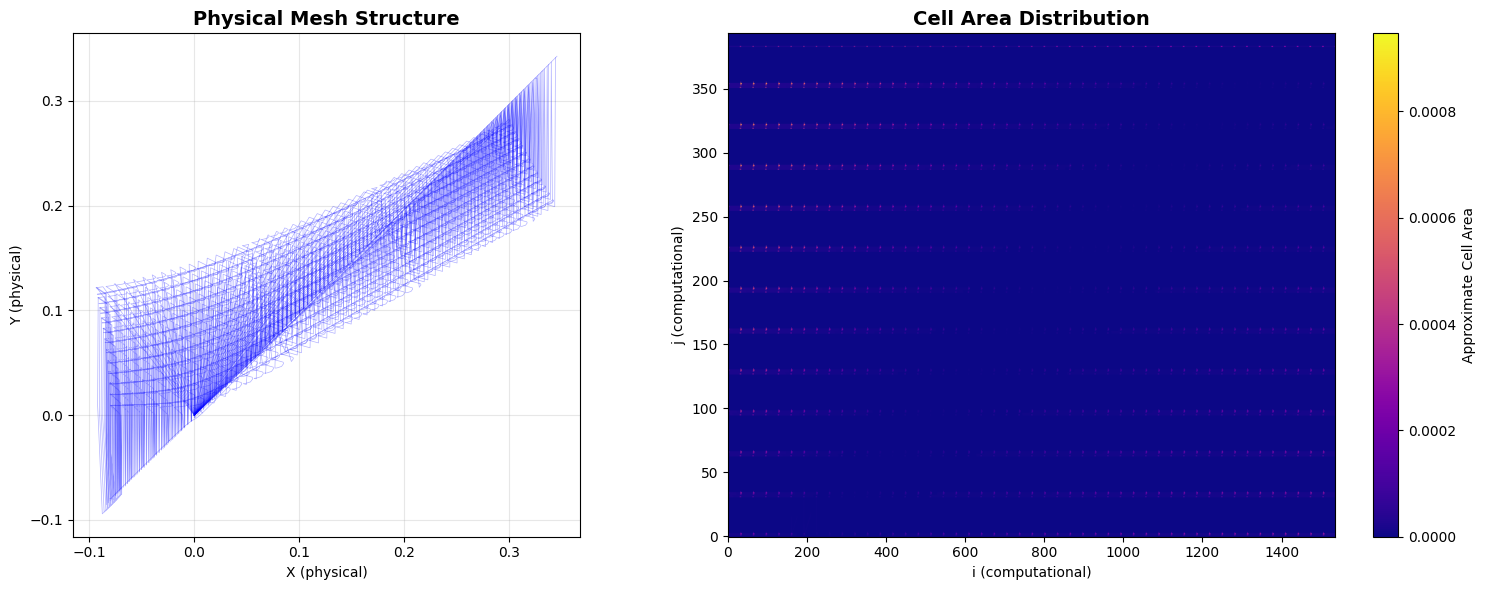


1️⃣  Comparing computational vs physical space...
📊 Loading density from: DMR.plot.000000.2d.hdf5
  Range: [0.00e+00, 8.00e+00]
💾 Saved: /standard/sds_baek_energetic/PSAAP - SAGEST/Chord_DoubleMachReflection_1536x394Cells_static/visualizations/dmr_density_comparison_t0.png


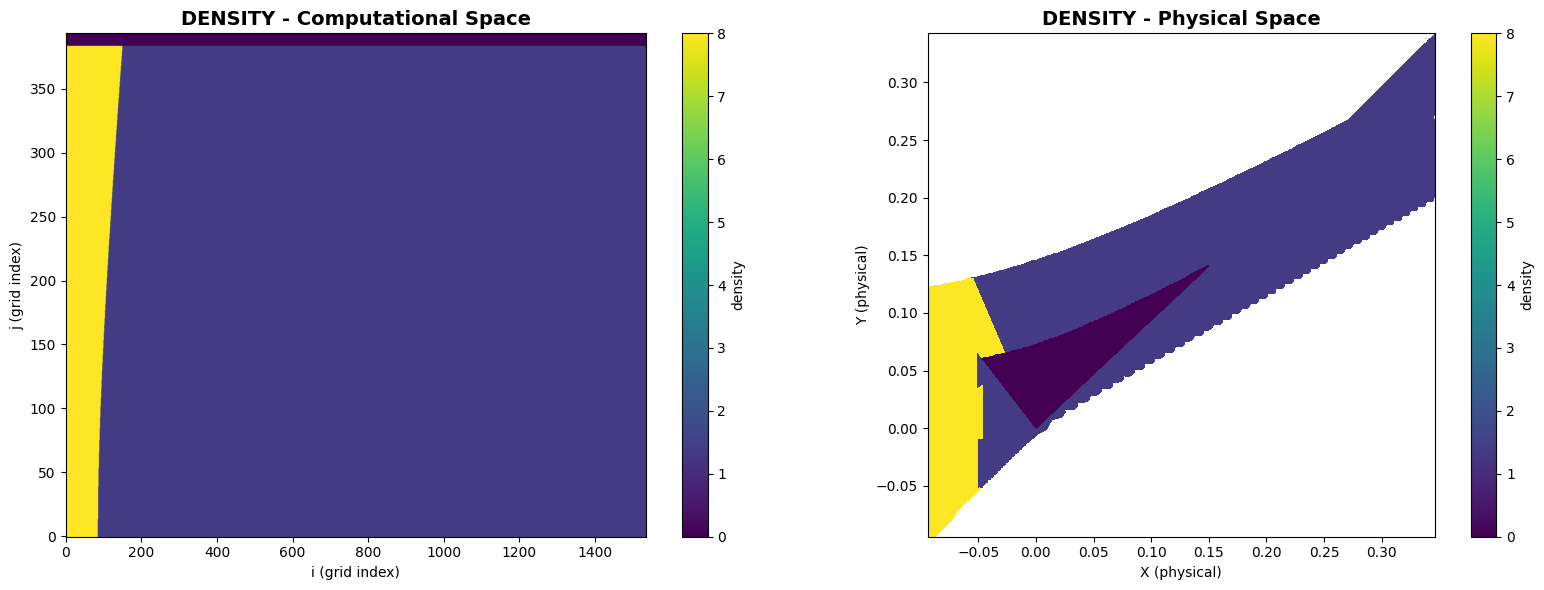


2️⃣  Visualizing all variables on physical mesh (t=0)...
📊 Loading all variables from: DMR.plot.000000.2d.hdf5
  density: [0.00e+00, 8.00e+00]
  x_momentum: [-1.34e-06, 6.60e+01]
  y_momentum: [0.00e+00, 0.00e+00]
  energy_density: [0.00e+00, 5.64e+02]
💾 Saved: /standard/sds_baek_energetic/PSAAP - SAGEST/Chord_DoubleMachReflection_1536x394Cells_static/visualizations/dmr_all_vars_physical_t0.png


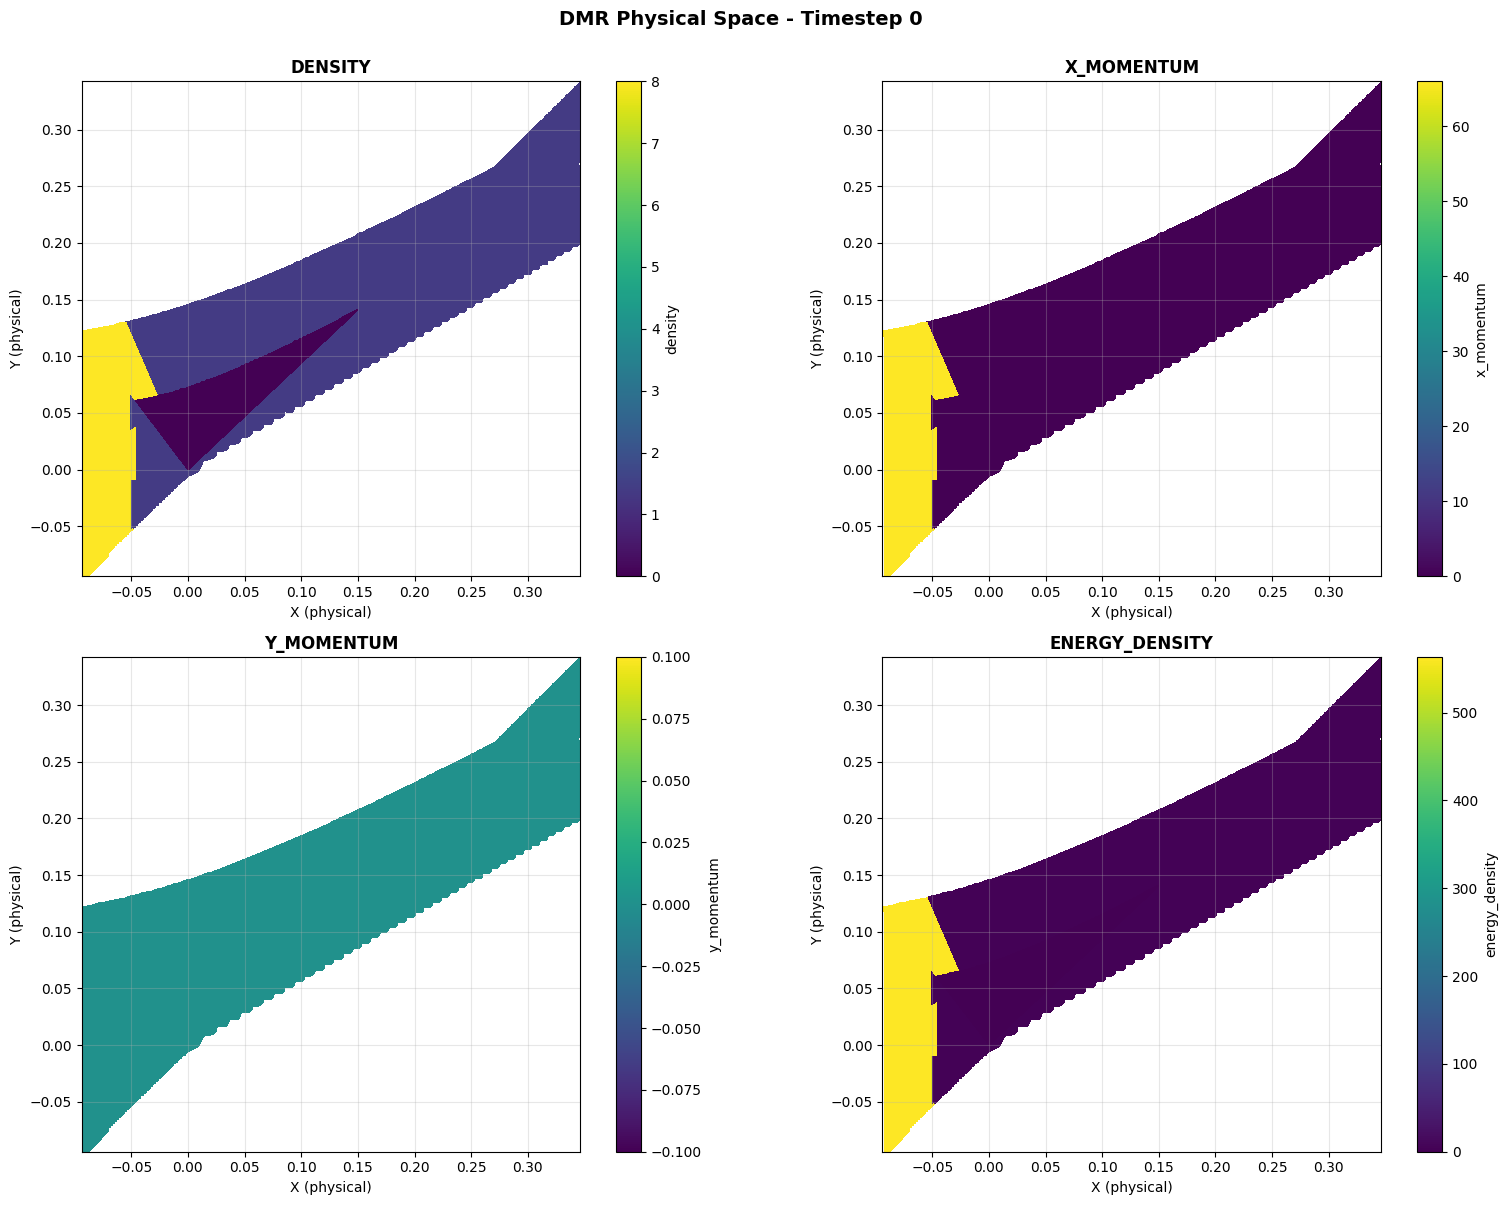


3️⃣  Visualizing physical mesh (t=1000)...
📊 Loading all variables from: DMR.plot.001000.2d.hdf5
  density: [0.00e+00, 1.87e+01]
  x_momentum: [-2.79e-02, 1.76e+02]
  y_momentum: [-3.50e+00, 1.00e+02]
  energy_density: [0.00e+00, 2.04e+03]
💾 Saved: /standard/sds_baek_energetic/PSAAP - SAGEST/Chord_DoubleMachReflection_1536x394Cells_static/visualizations/dmr_all_vars_physical_t1000.png


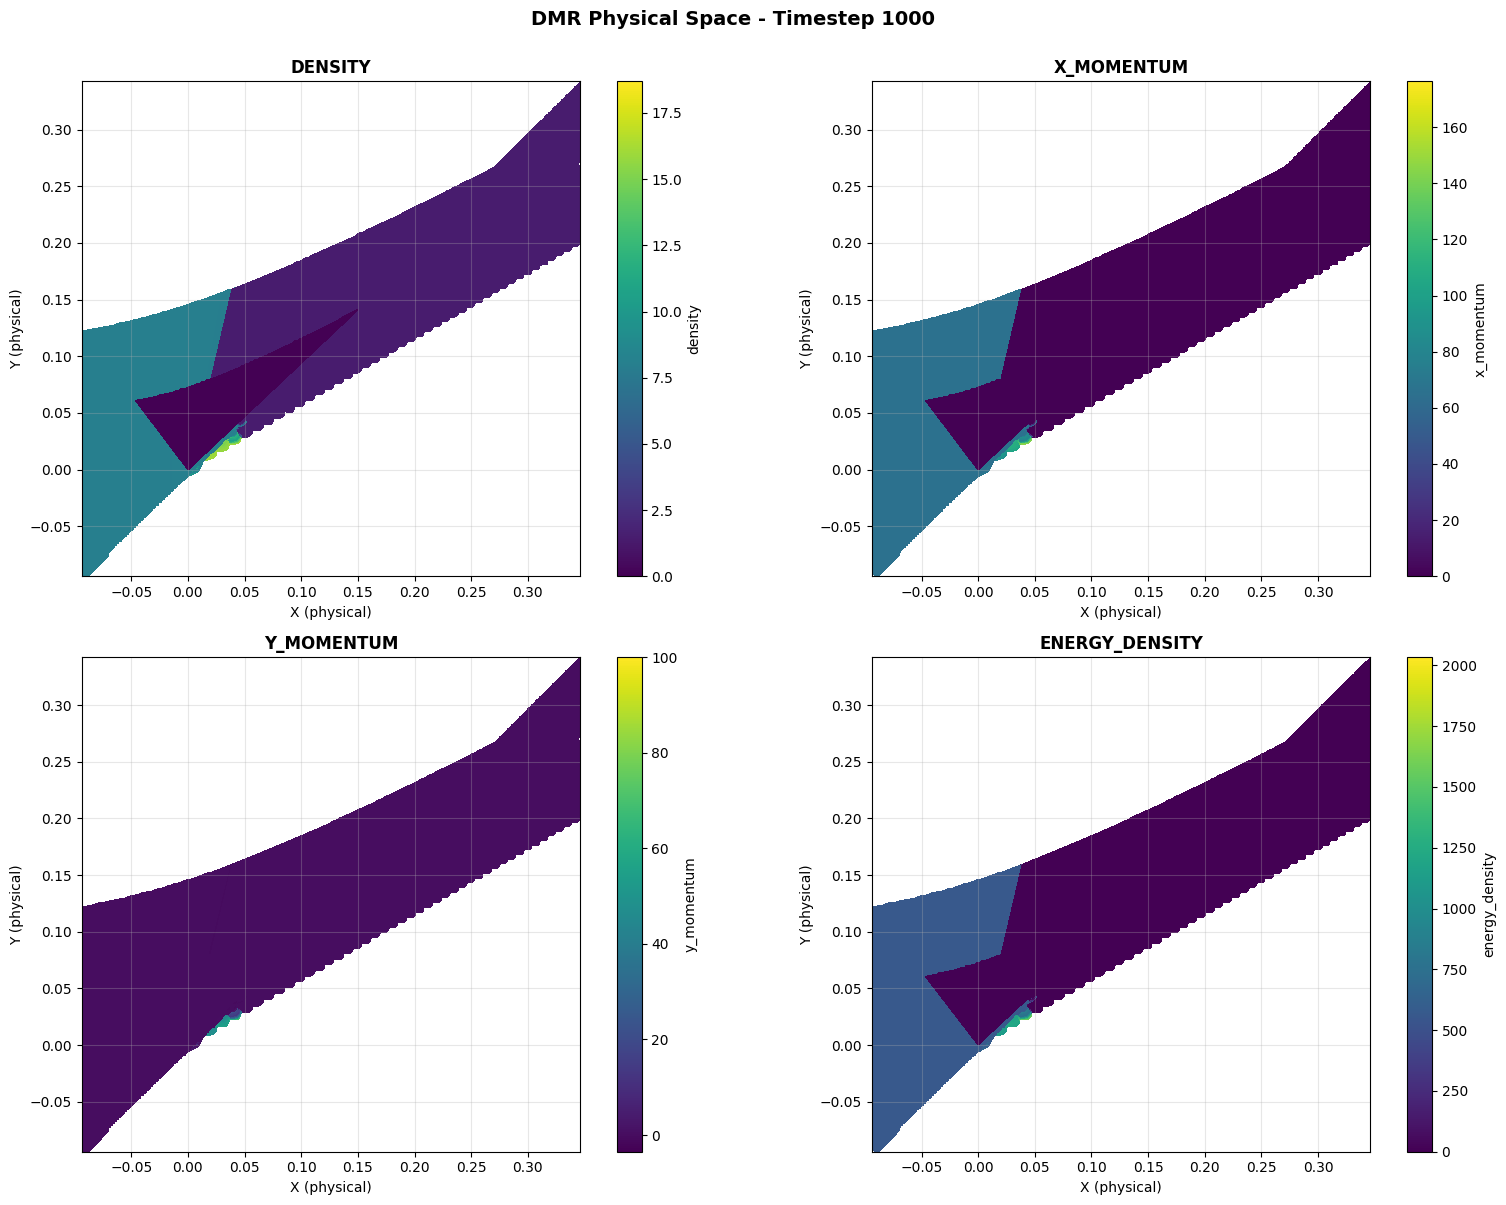


4️⃣  Create animation on physical mesh? (y/n): 

 y



  Animation settings:
  - ALL timesteps will be included (no stride)
  - Resume enabled: will skip existing PNG frames
  - GIF will be created automatically
  - PNG frames also saved for MP4 conversion if needed
🎬 Creating animation for density
  Total frames: 2501
  Stride: 1
  ✅ Found 2501 existing frames - resuming from where we left off
     Last completed frame: 2500
📊 Finding global range...
  Global range: [0.00e+00, 8.03e+00]
  Skipping existing frames... 2500 skipped
  ⏭️  Skipped 2501 existing frames

✅ PNG frames saved to: /standard/sds_baek_energetic/PSAAP - SAGEST/Chord_DoubleMachReflection_1536x394Cells_static/visualizations/animation_density_physical

💡 Alternative - Create MP4 with:
   ffmpeg -framerate 30 -pattern_type glob -i '/standard/sds_baek_energetic/PSAAP - SAGEST/Chord_DoubleMachReflection_1536x394Cells_static/visualizations/animation_density_physical/frame_*.png' \
          -c:v libx264 -pix_fmt yuv420p dmr_density_physical_mesh.mp4

5️⃣  Create GIF from exi

 y



  This will create a GIF from ALL existing PNG frames.
🎬 Creating GIF from 2501 PNG frames...
   Directory: /standard/sds_baek_energetic/PSAAP - SAGEST/Chord_DoubleMachReflection_1536x394Cells_static/visualizations/animation_density_physical
   Loading frame 2501/2501...
   All frames loaded!

💾 Saving GIF to: /standard/sds_baek_energetic/PSAAP - SAGEST/Chord_DoubleMachReflection_1536x394Cells_static/visualizations/dmr_density_physical_mesh.gif
✅ GIF saved successfully!
   Path: /standard/sds_baek_energetic/PSAAP - SAGEST/Chord_DoubleMachReflection_1536x394Cells_static/visualizations/dmr_density_physical_mesh.gif
   Frames: 2501
   FPS: 30
   Duration: 83.4 seconds

✅ Visualization complete!


In [2]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import re
import io
from PIL import Image

class DMRVisualizer:
    """
    Visualize Double Mach Reflection simulation data.
    Handles Chombo HDF5 format with mapped coordinates (mesh data).
    """
    
    def __init__(self, data_dir):
        self.data_dir = Path(data_dir)
        self.grid_width = 1536
        self.grid_height = 394  # FIXED: Was 384, should be 394
        self.var_names = ['density', 'x_momentum', 'y_momentum', 'energy_density']
    
    def get_timestep_files(self, pattern="DMR.plot.*.2d.hdf5"):
        """Get sorted list of timestep files (excluding map files)."""
        files = [f for f in self.data_dir.glob(pattern) if '.map.' not in f.name]
        
        def extract_timestep(filename):
            match = re.search(r'\.(\d+)\.2d\.hdf5', str(filename))
            return int(match.group(1)) if match else 0
        
        return sorted(files, key=extract_timestep)
    
    def get_map_file(self, data_file):
        """Get corresponding map file for a data file."""
        map_filename = data_file.name.replace('.2d.hdf5', '.2d.map.hdf5')
        map_file = data_file.parent / map_filename
        return map_file if map_file.exists() else None
    
    def debug_box_structure(self, data_file):
        """Debug the box structure to understand data layout."""
        print(f"\n{'='*80}")
        print(f"🔍 DEBUGGING BOX STRUCTURE: {data_file.name}")
        print(f"{'='*80}")
        
        with h5py.File(data_file, 'r') as f:
            # Get number of variables from root attributes
            n_vars = int(f.attrs.get('num_components', 4))
            
            level = f['level_0']
            boxes = level['boxes'][:]
            data_flat = level['data:datatype=0'][:]
            offsets = level['data:offsets=0'][:]
            
            print(f"\n📊 Data Overview:")
            print(f"  Number of variables (from file): {n_vars}")
            print(f"  Total boxes: {len(boxes)}")
            print(f"  Data array shape: {data_flat.shape}")
            print(f"  Offsets shape: {offsets.shape} (one per box + 1)")
            
            print(f"\n📦 Box Analysis:")
            total_cells = 0
            empty_boxes = 0
            box_sizes = []
            
            for i, box in enumerate(boxes):
                ni = box['hi_i'] - box['lo_i'] + 1
                nj = box['hi_j'] - box['lo_j'] + 1
                box_size = ni * nj
                box_sizes.append(box_size)
                total_cells += box_size
                
                if box_size == 0:
                    empty_boxes += 1
                
                if i < 5:  # Print first 5 boxes
                    print(f"  Box {i}: lo=({box['lo_i']}, {box['lo_j']}), "
                          f"hi=({box['hi_i']}, {box['hi_j']}), size={ni}x{nj}={box_size}")
            
            print(f"\n  Total cells from boxes: {total_cells:,}")
            print(f"  Expected grid: {self.grid_width} × {self.grid_height} = {self.grid_width * self.grid_height:,}")
            print(f"  Empty boxes: {empty_boxes}")
            print(f"  Min box size: {min(box_sizes)}")
            print(f"  Max box size: {max(box_sizes)}")
            print(f"  Mean box size: {np.mean(box_sizes):.1f}")
            
            # Check if data matches expected size
            expected_data_size = total_cells * n_vars
            actual_data_size = data_flat.shape[0]
            
            print(f"\n📐 Data Size Check:")
            print(f"  Expected: {expected_data_size:,} ({total_cells:,} cells × {n_vars} vars)")
            print(f"  Actual: {actual_data_size:,}")
            print(f"  Match: {'✅' if expected_data_size == actual_data_size else '❌'}")
            
            # Analyze offsets
            print(f"\n📊 Offset Analysis:")
            print(f"  First 10 offsets: {offsets[:10]}")
            offset_diffs = np.diff(offsets)
            print(f"  Data per box (first 10): {offset_diffs[:10]}")
            print(f"  Expected per box: {box_sizes[0] * n_vars}")
            
            return boxes, data_flat, offsets, n_vars
    
    def cell_to_node_coords(self, x_cell, y_cell):
        """
        Convert cell-centered coordinates to node-centered coordinates for pcolormesh.
        Uses linear extrapolation at boundaries and averaging in interior.
        
        Args:
            x_cell, y_cell: Cell-centered coordinate arrays of shape (nj, ni)
            
        Returns:
            x_node, y_node: Node-centered coordinate arrays of shape (nj+1, ni+1)
        """
        nj, ni = x_cell.shape
        x_node = np.zeros((nj + 1, ni + 1))
        y_node = np.zeros((nj + 1, ni + 1))
        
        # Interior nodes: average of surrounding cell centers
        x_node[1:-1, 1:-1] = 0.25 * (x_cell[:-1, :-1] + x_cell[1:, :-1] + 
                                      x_cell[:-1, 1:] + x_cell[1:, 1:])
        y_node[1:-1, 1:-1] = 0.25 * (y_cell[:-1, :-1] + y_cell[1:, :-1] + 
                                      y_cell[:-1, 1:] + y_cell[1:, 1:])
        
        # Edge nodes: average of two adjacent cell centers
        # Bottom edge
        x_node[0, 1:-1] = 0.5 * (x_cell[0, :-1] + x_cell[0, 1:])
        y_node[0, 1:-1] = 0.5 * (y_cell[0, :-1] + y_cell[0, 1:])
        
        # Top edge
        x_node[-1, 1:-1] = 0.5 * (x_cell[-1, :-1] + x_cell[-1, 1:])
        y_node[-1, 1:-1] = 0.5 * (y_cell[-1, :-1] + y_cell[-1, 1:])
        
        # Left edge
        x_node[1:-1, 0] = 0.5 * (x_cell[:-1, 0] + x_cell[1:, 0])
        y_node[1:-1, 0] = 0.5 * (y_cell[:-1, 0] + y_cell[1:, 0])
        
        # Right edge
        x_node[1:-1, -1] = 0.5 * (x_cell[:-1, -1] + x_cell[1:, -1])
        y_node[1:-1, -1] = 0.5 * (y_cell[:-1, -1] + y_cell[1:, -1])
        
        # Corner nodes: extrapolate from nearby cell centers
        # Bottom-left corner
        x_node[0, 0] = 1.5 * x_cell[0, 0] - 0.5 * x_cell[0, 1]
        y_node[0, 0] = 1.5 * y_cell[0, 0] - 0.5 * y_cell[1, 0]
        
        # Bottom-right corner
        x_node[0, -1] = 1.5 * x_cell[0, -1] - 0.5 * x_cell[0, -2]
        y_node[0, -1] = 1.5 * y_cell[0, -1] - 0.5 * y_cell[1, -1]
        
        # Top-left corner
        x_node[-1, 0] = 1.5 * x_cell[-1, 0] - 0.5 * x_cell[-1, 1]
        y_node[-1, 0] = 1.5 * y_cell[-1, 0] - 0.5 * y_cell[-2, 0]
        
        # Top-right corner
        x_node[-1, -1] = 1.5 * x_cell[-1, -1] - 0.5 * x_cell[-1, -2]
        y_node[-1, -1] = 1.5 * y_cell[-1, -1] - 0.5 * y_cell[-2, -1]
        
        return x_node, y_node
    
    def read_chombo_data(self, data_file, map_file=None):
        """
        Read Chombo HDF5 data.
        CRITICAL: offsets array has one entry per BOX, not per variable!
        
        Returns:
            grids: dict of 2D arrays for each variable (computational space)
            coordinates: dict with 'x' and 'y' physical coordinates (cell-centered, if map_file provided)
        """
        with h5py.File(data_file, 'r') as f:
            # Get number of variables from file attributes
            n_vars = int(f.attrs.get('num_components', 4))
            
            level = f['level_0']
            boxes = level['boxes'][:]
            data_flat = level['data:datatype=0'][:]
            offsets = level['data:offsets=0'][:]
            
            # Initialize grids in computational space
            grids = {name: np.zeros((self.grid_height, self.grid_width)) 
                    for name in self.var_names}
            
            # Reconstruct 2D grids using offsets
            # offsets[i] to offsets[i+1] gives ALL data for box i
            for i, box in enumerate(boxes):
                ni = box['hi_i'] - box['lo_i'] + 1
                nj = box['hi_j'] - box['lo_j'] + 1
                box_size = ni * nj
                
                if box_size == 0:
                    continue
                
                # Get data slice for this box using offsets
                start_idx = offsets[i]
                end_idx = offsets[i + 1]
                box_data = data_flat[start_idx:end_idx]
                
                # Extract each variable from the box data
                # Data layout: [var0_cell0, var0_cell1, ..., var1_cell0, var1_cell1, ...]
                for var_idx in range(min(n_vars, len(self.var_names))):
                    var_start = var_idx * box_size
                    var_end = (var_idx + 1) * box_size
                    var_data = box_data[var_start:var_end]
                    
                    if len(var_data) == box_size:
                        var_data_2d = var_data.reshape((nj, ni))
                        grids[self.var_names[var_idx]][box['lo_j']:box['hi_j']+1, 
                                                       box['lo_i']:box['hi_i']+1] = var_data_2d
        
        # Read physical coordinates from map file (CELL-CENTERED)
        coordinates = None
        if map_file and map_file.exists():
            with h5py.File(map_file, 'r') as f:
                n_coords = int(f.attrs.get('num_components', 2))
                
                level = f['level_0']
                boxes = level['boxes'][:]
                coord_flat = level['data:datatype=0'][:]
                offsets = level['data:offsets=0'][:]
                
                # FIXED: Cell-centered coordinates (same size as data)
                coord_grids = {
                    'x': np.zeros((self.grid_height, self.grid_width)),
                    'y': np.zeros((self.grid_height, self.grid_width))
                }
                
                for i, box in enumerate(boxes):
                    ni = box['hi_i'] - box['lo_i'] + 1
                    nj = box['hi_j'] - box['lo_j'] + 1
                    box_size = ni * nj
                    
                    if box_size == 0:
                        continue
                    
                    # Get coordinate data using offsets
                    start_idx = offsets[i]
                    end_idx = offsets[i + 1]
                    box_coords = coord_flat[start_idx:end_idx]
                    
                    # Extract x and y coordinates
                    if len(box_coords) >= box_size * n_coords:
                        x_data = box_coords[0:box_size].reshape((nj, ni))
                        y_data = box_coords[box_size:2*box_size].reshape((nj, ni))
                        
                        coord_grids['x'][box['lo_j']:box['hi_j']+1,
                                        box['lo_i']:box['hi_i']+1] = x_data
                        coord_grids['y'][box['lo_j']:box['hi_j']+1,
                                        box['lo_i']:box['hi_i']+1] = y_data
                
                # FIXED: Return cell-centered coordinates directly
                coordinates = coord_grids
        
        return grids, coordinates
    
    def visualize_mesh_structure(self, timestep_idx=0, save_dir=None):
        """Visualize the physical mesh structure showing coordinate mapping."""
        files = self.get_timestep_files()
        if timestep_idx >= len(files):
            print(f"❌ Timestep {timestep_idx} not found")
            return
        
        data_file = files[timestep_idx]
        map_file = self.get_map_file(data_file)
        
        if not map_file or not map_file.exists():
            print(f"❌ Map file not found: {map_file}")
            return
        
        print(f"📍 Reading mesh coordinates from: {map_file.name}")
        _, coordinates = self.read_chombo_data(data_file, map_file)
        
        if coordinates is None:
            print("❌ No coordinates loaded")
            return
        
        x_cell = coordinates['x']
        y_cell = coordinates['y']
        
        # Convert to node coordinates for visualization
        x_node, y_node = self.cell_to_node_coords(x_cell, y_cell)
        
        print(f"  Cell-centered coords: {x_cell.shape}")
        print(f"  Node-centered coords: {x_node.shape}")
        print(f"  X range: [{x_cell.min():.3f}, {x_cell.max():.3f}]")
        print(f"  Y range: [{y_cell.min():.3f}, {y_cell.max():.3f}]")
        
        # Plot mesh structure
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
        
        # Left: Show mesh lines
        ax = axes[0]
        # Plot every Nth grid line to avoid clutter
        stride = max(1, self.grid_width // 50)
        for i in range(0, x_node.shape[0], stride):
            ax.plot(x_node[i, :], y_node[i, :], 'b-', alpha=0.3, linewidth=0.5)
        for j in range(0, x_node.shape[1], stride):
            ax.plot(x_node[:, j], y_node[:, j], 'b-', alpha=0.3, linewidth=0.5)
        ax.set_title("Physical Mesh Structure", fontsize=14, fontweight='bold')
        ax.set_xlabel("X (physical)")
        ax.set_ylabel("Y (physical)")
        ax.set_aspect('equal', adjustable='box')
        ax.grid(True, alpha=0.3)
        
        # Right: Show cell area distribution
        ax = axes[1]
        # Compute approximate cell areas (Jacobian determinant)
        dx_di = np.diff(x_cell, axis=1)
        dy_di = np.diff(y_cell, axis=1)
        dx_dj = np.diff(x_cell, axis=0)
        dy_dj = np.diff(y_cell, axis=0)
        
        # Use centered differences where possible
        cell_area = np.zeros_like(x_cell)
        cell_area[1:-1, 1:-1] = np.abs(
            (x_cell[1:-1, 2:] - x_cell[1:-1, :-2]) * (y_cell[2:, 1:-1] - y_cell[:-2, 1:-1]) -
            (y_cell[1:-1, 2:] - y_cell[1:-1, :-2]) * (x_cell[2:, 1:-1] - x_cell[:-2, 1:-1])
        ) / 4.0
        
        im = ax.imshow(cell_area, origin='lower', aspect='auto', cmap='plasma')
        ax.set_title("Cell Area Distribution", fontsize=14, fontweight='bold')
        ax.set_xlabel("i (computational)")
        ax.set_ylabel("j (computational)")
        plt.colorbar(im, ax=ax, label='Approximate Cell Area')
        
        plt.tight_layout()
        
        if save_dir:
            save_path = Path(save_dir)
            save_path.mkdir(exist_ok=True, parents=True)
            filename = save_path / f"dmr_mesh_structure_t{timestep_idx}.png"
            plt.savefig(filename, dpi=150, bbox_inches='tight')
            print(f"💾 Saved: {filename}")
        
        plt.show()
    
    def compare_computational_vs_physical(self, timestep_idx=0, variable='density', 
                                         save_dir=None):
        """Compare visualization in computational vs physical space."""
        files = self.get_timestep_files()
        if timestep_idx >= len(files):
            print(f"❌ Timestep {timestep_idx} not found")
            return
        
        data_file = files[timestep_idx]
        map_file = self.get_map_file(data_file)
        
        print(f"📊 Loading {variable} from: {data_file.name}")
        grids, coordinates = self.read_chombo_data(data_file, map_file)
        
        data = grids[variable]
        vmin, vmax = data.min(), data.max()
        print(f"  Range: [{vmin:.2e}, {vmax:.2e}]")
        
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
        
        # Left: Computational space
        ax = axes[0]
        im = ax.imshow(data, origin='lower', aspect='auto', cmap='viridis', 
                      vmin=vmin, vmax=vmax)
        ax.set_title(f"{variable.upper()} - Computational Space", 
                    fontsize=14, fontweight='bold')
        ax.set_xlabel("i (grid index)")
        ax.set_ylabel("j (grid index)")
        plt.colorbar(im, ax=ax, label=variable)
        
        # Right: Physical space
        ax = axes[1]
        if coordinates is not None:
            x_cell = coordinates['x']
            y_cell = coordinates['y']
            x_node, y_node = self.cell_to_node_coords(x_cell, y_cell)
            
            im = ax.pcolormesh(x_node, y_node, data, cmap='viridis', 
                             shading='flat', vmin=vmin, vmax=vmax)
            ax.set_title(f"{variable.upper()} - Physical Space", 
                        fontsize=14, fontweight='bold')
            ax.set_xlabel("X (physical)")
            ax.set_ylabel("Y (physical)")
            ax.set_aspect('equal', adjustable='box')
            plt.colorbar(im, ax=ax, label=variable)
        else:
            ax.text(0.5, 0.5, 'No coordinate mapping available', 
                   ha='center', va='center', transform=ax.transAxes)
            ax.axis('off')
        
        plt.tight_layout()
        
        if save_dir:
            save_path = Path(save_dir)
            save_path.mkdir(exist_ok=True, parents=True)
            filename = save_path / f"dmr_{variable}_comparison_t{timestep_idx}.png"
            plt.savefig(filename, dpi=150, bbox_inches='tight')
            print(f"💾 Saved: {filename}")
        
        plt.show()
    
    def visualize_on_physical_mesh(self, timestep_idx=0, save_dir=None):
        """Visualize all variables on the physical mesh."""
        files = self.get_timestep_files()
        if timestep_idx >= len(files):
            print(f"❌ Timestep {timestep_idx} not found")
            return
        
        data_file = files[timestep_idx]
        map_file = self.get_map_file(data_file)
        
        if not map_file or not map_file.exists():
            print(f"❌ Map file not found")
            return
        
        print(f"📊 Loading all variables from: {data_file.name}")
        grids, coordinates = self.read_chombo_data(data_file, map_file)
        
        if coordinates is None:
            print("❌ No coordinates loaded")
            return
        
        x_cell = coordinates['x']
        y_cell = coordinates['y']
        x_node, y_node = self.cell_to_node_coords(x_cell, y_cell)
        
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        axes = axes.flatten()
        
        for idx, var_name in enumerate(self.var_names):
            ax = axes[idx]
            data = grids[var_name]
            
            vmin, vmax = data.min(), data.max()
            im = ax.pcolormesh(x_node, y_node, data, cmap='viridis', 
                             shading='flat', vmin=vmin, vmax=vmax)
            ax.set_title(f"{var_name.upper()}", fontsize=12, fontweight='bold')
            ax.set_xlabel("X (physical)")
            ax.set_ylabel("Y (physical)")
            ax.set_aspect('equal', adjustable='box')
            ax.grid(True, alpha=0.3)
            plt.colorbar(im, ax=ax, label=var_name)
            
            print(f"  {var_name}: [{vmin:.2e}, {vmax:.2e}]")
        
        plt.suptitle(f"DMR Physical Space - Timestep {timestep_idx}", 
                    fontsize=14, fontweight='bold', y=1.00)
        plt.tight_layout()
        
        if save_dir:
            save_path = Path(save_dir)
            save_path.mkdir(exist_ok=True, parents=True)
            filename = save_path / f"dmr_all_vars_physical_t{timestep_idx}.png"
            plt.savefig(filename, dpi=150, bbox_inches='tight')
            print(f"💾 Saved: {filename}")
        
        plt.show()
    
    def create_gif_from_pngs(self, variable='density', save_dir=None, fps=30):
        """
        Create a GIF from existing PNG frames in the animation directory.
        Use this after all frames have been generated.
        
        Args:
            variable: The variable name (used to find the correct directory)
            save_dir: Directory where animation frames are saved
            fps: Frames per second for the GIF
        """
        # Setup paths
        if save_dir:
            frames_path = Path(save_dir) / f"animation_{variable}_physical"
        else:
            frames_path = Path(f"animation_{variable}_physical")
        
        if not frames_path.exists():
            print(f"❌ Frames directory not found: {frames_path}")
            return
        
        # Find all PNG frames
        png_files = sorted(frames_path.glob("frame_*.png"))
        
        if not png_files:
            print(f"❌ No PNG frames found in {frames_path}")
            return
        
        print(f"🎬 Creating GIF from {len(png_files)} PNG frames...")
        print(f"   Directory: {frames_path}")
        
        # Load all frames
        gif_frames = []
        for i, png_file in enumerate(png_files):
            if i % 100 == 0:
                print(f"   Loading frame {i+1}/{len(png_files)}...", end='\r')
            gif_frames.append(Image.open(png_file))
        
        print(f"\n   All frames loaded!")
        
        # Create GIF
        gif_path = frames_path.parent / f"dmr_{variable}_physical_mesh.gif"
        print(f"\n💾 Saving GIF to: {gif_path}")
        
        # Calculate duration per frame in milliseconds
        duration = int(1000 / fps)
        
        gif_frames[0].save(
            gif_path,
            save_all=True,
            append_images=gif_frames[1:],
            duration=duration,
            loop=0,
            optimize=False
        )
        
        print(f"✅ GIF saved successfully!")
        print(f"   Path: {gif_path}")
        print(f"   Frames: {len(gif_frames)}")
        print(f"   FPS: {fps}")
        print(f"   Duration: {len(gif_frames)/fps:.1f} seconds")
    
    def animate_on_physical_mesh(self, variable='density', stride=1, max_frames=None,
                                save_dir=None, create_gif=True, fps=30, resume=True):
        """
        Create animation frames on the physical mesh.
        Saves PNG frames and optionally creates a GIF.
        
        Args:
            resume: If True, skip frames that already exist as PNG files
        """
        files = self.get_timestep_files()
        if max_frames:
            files = files[::stride][:max_frames]
        else:
            files = files[::stride]
        
        if not files:
            print("❌ No files found")
            return
        
        print(f"🎬 Creating animation for {variable}")
        print(f"  Total frames: {len(files)}")
        print(f"  Stride: {stride}")
        
        # Setup output directory
        if save_dir:
            output_path = Path(save_dir) / f"animation_{variable}_physical"
        else:
            output_path = Path(f"animation_{variable}_physical")
        output_path.mkdir(exist_ok=True, parents=True)
        
        # Check for existing frames if resuming
        existing_frames = set()
        if resume:
            existing_pngs = list(output_path.glob("frame_*.png"))
            existing_frames = {int(f.stem.split('_')[1]) for f in existing_pngs}
            if existing_frames:
                print(f"  ✅ Found {len(existing_frames)} existing frames - resuming from where we left off")
                print(f"     Last completed frame: {max(existing_frames)}")
            else:
                print(f"  Starting fresh (no existing frames found)")
        
        # Find global range across all timesteps for consistent colormap
        print("📊 Finding global range...")
        all_min, all_max = float('inf'), float('-inf')
        for file in files[:min(10, len(files))]:  # Sample first 10 for range
            try:
                grids, _ = self.read_chombo_data(file)
                data = grids[variable]
                all_min = min(all_min, data.min())
                all_max = max(all_max, data.max())
            except Exception as e:
                print(f"  ⚠️ Error sampling {file.name}: {e}")
        
        vmin, vmax = all_min, all_max
        print(f"  Global range: [{vmin:.2e}, {vmax:.2e}]")
        
        # Generate frames
        gif_frames = []
        skipped_count = 0
        for frame_idx, file in enumerate(files):
            # Check if frame already exists
            if resume and frame_idx in existing_frames:
                skipped_count += 1
                if skipped_count % 100 == 0:
                    print(f"  Skipping existing frames... {skipped_count} skipped", end='\r')
                continue
            
            try:
                print(f"  Frame {frame_idx + 1}/{len(files)}: {file.name}", end='\r')
                
                # Read data
                grids, coordinates = self.read_chombo_data(file, self.get_map_file(file))
                
                if coordinates is None:
                    print(f"\n  ⚠️ No coordinates for {file.name}, skipping")
                    continue
                
                data = grids[variable]
                x_cell = coordinates['x']
                y_cell = coordinates['y']
                
                # Convert to node coordinates
                x_node, y_node = self.cell_to_node_coords(x_cell, y_cell)
                
                # Extract timestep number for title
                match = re.search(r'\.(\d+)\.2d\.hdf5', file.name)
                timestep = int(match.group(1)) if match else frame_idx
                
                # Plot
                fig, ax = plt.subplots(figsize=(14, 6))
                im = ax.pcolormesh(x_node, y_node, data, cmap='viridis', 
                                 shading='flat', vmin=vmin, vmax=vmax)
                ax.set_title(f"{variable.upper()} - Timestep {timestep} ({file.name})", 
                           fontsize=14, fontweight='bold')
                ax.set_xlabel('X (physical)')
                ax.set_ylabel('Y (physical)')
                ax.set_aspect('equal', adjustable='box')
                ax.grid(True, alpha=0.3)
                plt.colorbar(im, ax=ax, label=variable)
                
                # Save PNG
                filename = output_path / f"frame_{frame_idx:06d}.png"
                plt.savefig(filename, dpi=100, bbox_inches='tight')
                
                # Add to GIF frames
                if create_gif:
                    buf = io.BytesIO()
                    plt.savefig(buf, format='png', dpi=100, bbox_inches='tight')
                    buf.seek(0)
                    gif_frames.append(Image.open(buf))
                
                plt.close()
                
            except Exception as e:
                print(f"\n  ⚠️ Error at frame {frame_idx}: {e}")
                continue
        
        if skipped_count > 0:
            print(f"\n  ⏭️  Skipped {skipped_count} existing frames")
        
        print(f"\n✅ PNG frames saved to: {output_path}")
        
        # Create GIF
        if create_gif and gif_frames:
            gif_path = output_path.parent / f"dmr_{variable}_physical_mesh.gif"
            print(f"\n🎬 Creating GIF...")
            
            # Calculate duration per frame in milliseconds
            duration = int(1000 / fps)
            
            gif_frames[0].save(
                gif_path,
                save_all=True,
                append_images=gif_frames[1:],
                duration=duration,
                loop=0,
                optimize=False
            )
            print(f"✅ GIF saved: {gif_path}")
            print(f"   Frames: {len(gif_frames)}, FPS: {fps}")
        
        # Also provide ffmpeg command for MP4 if desired
        print(f"\n💡 Alternative - Create MP4 with:")
        print(f"   ffmpeg -framerate {fps} -pattern_type glob -i '{output_path}/frame_*.png' \\")
        print(f"          -c:v libx264 -pix_fmt yuv420p dmr_{variable}_physical_mesh.mp4")
    
    def visualize_time_evolution(self, timesteps=[0, 500, 1000, 1500, 2000, 2500], 
                                 variable='density', save_dir=None):
        """
        Show evolution of a variable across multiple timesteps.
        """
        files = self.get_timestep_files()
        valid_timesteps = [t for t in timesteps if t < len(files)]
        
        if not valid_timesteps:
            print("❌ No valid timesteps")
            return
        
        print(f"📈 Loading {variable} evolution...")
        
        # Load data and find global range
        all_data = []
        for idx in valid_timesteps:
            try:
                grids, _ = self.read_chombo_data(files[idx])
                all_data.append(grids[variable])
            except Exception as e:
                print(f"  ⚠️ Error at timestep {idx}: {e}")
                all_data.append(None)
        
        valid_data = [d for d in all_data if d is not None]
        if not valid_data:
            print("❌ No valid data")
            return
        
        vmin = min(d.min() for d in valid_data)
        vmax = max(d.max() for d in valid_data)
        print(f"  Range: [{vmin:.2e}, {vmax:.2e}]")
        
        # Plot
        fig, axes = plt.subplots(2, 3, figsize=(18, 10))
        axes = axes.flatten()
        
        for i, (idx, data) in enumerate(zip(valid_timesteps[:6], all_data[:6])):
            ax = axes[i]
            if data is not None:
                im = ax.imshow(data, origin='lower', aspect='auto', 
                             cmap='viridis', vmin=vmin, vmax=vmax)
                ax.set_title(f"Timestep {idx}", fontsize=12)
                plt.colorbar(im, ax=ax)
            else:
                ax.text(0.5, 0.5, f'Error\ntimestep {idx}', 
                       ha='center', va='center', transform=ax.transAxes)
                ax.axis('off')
        
        for i in range(len(valid_timesteps), 6):
            axes[i].axis('off')
        
        plt.suptitle(f"DMR - {variable.upper()} Evolution", 
                    fontsize=14, fontweight='bold')
        plt.tight_layout()
        
        if save_dir:
            save_path = Path(save_dir)
            save_path.mkdir(exist_ok=True, parents=True)
            filename = save_path / f"dmr_{variable}_evolution.png"
            plt.savefig(filename, dpi=150, bbox_inches='tight')
            print(f"💾 Saved: {filename}")
        
        plt.show()


def main():
    """Main visualization script."""
    BASE_DIR = "/standard/sds_baek_energetic/PSAAP - SAGEST/Chord_DoubleMachReflection_1536x394Cells_static/static_noAMR_mapped_coordinates"
    SAVE_DIR = "/standard/sds_baek_energetic/PSAAP - SAGEST/Chord_DoubleMachReflection_1536x394Cells_static/visualizations"
    
    print("="*80)
    print("🎨 DMR DATA VISUALIZATION TOOL (FIXED)")
    print("="*80)
    
    visualizer = DMRVisualizer(BASE_DIR)
    
    # Visualize mesh structure
    print("\n0️⃣  Analyzing mesh structure...")
    visualizer.visualize_mesh_structure(timestep_idx=0, save_dir=SAVE_DIR)
    
    # Compare computational vs physical
    print("\n1️⃣  Comparing computational vs physical space...")
    visualizer.compare_computational_vs_physical(timestep_idx=0, variable='density', 
                                                save_dir=SAVE_DIR)
    
    # Visualize on physical mesh
    print("\n2️⃣  Visualizing all variables on physical mesh (t=0)...")
    visualizer.visualize_on_physical_mesh(timestep_idx=0, save_dir=SAVE_DIR)
    
    # Middle timestep on physical mesh
    print("\n3️⃣  Visualizing physical mesh (t=1000)...")
    visualizer.visualize_on_physical_mesh(timestep_idx=1000, save_dir=SAVE_DIR)
    
    # Optional: create animation
    print("\n4️⃣  Create animation on physical mesh? (y/n): ", end="")
    create_anim = input().lower().strip() in ['y', 'yes']
    
    if create_anim:
        print("\n  Animation settings:")
        print("  - ALL timesteps will be included (no stride)")
        print("  - Resume enabled: will skip existing PNG frames")
        print("  - GIF will be created automatically")
        print("  - PNG frames also saved for MP4 conversion if needed")
        
        visualizer.animate_on_physical_mesh(
            variable='density',
            stride=1,  # Include EVERY timestep
            max_frames=None,  # No limit - process all files
            save_dir=SAVE_DIR,
            create_gif=True,  # Creates GIF directly
            fps=30,  # Frames per second
            resume=True  # Skip existing frames and resume where stopped
        )
    
    # Optional: create GIF from existing frames
    print("\n5️⃣  Create GIF from existing PNG frames? (y/n): ", end="")
    create_gif_from_pngs = input().lower().strip() in ['y', 'yes']
    
    if create_gif_from_pngs:
        print("\n  This will create a GIF from ALL existing PNG frames.")
        visualizer.create_gif_from_pngs(
            variable='density',
            save_dir=SAVE_DIR,
            fps=30
        )
    
    print("\n✅ Visualization complete!")


if __name__ == "__main__":
    main()